## 0. Goal
Run VAE first to reduce spectrogram dimensions from 128*128 to 32 latent features. Then run UMAP and HDBSCAN. <br>
Use Goffinet spectrogramming and VAE network. <br>
Use fixed parameters, but input datasets with very short syllable removed. <br>
Run one bird at a time

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import calinski_harabasz_score

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import hopkins2
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)
importlib.reload(hopkins2)

<module 'hopkins2' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/hopkins2.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
bd = 'pair4RigACU68'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clim = [1.5,7]
# what syllable to analyze
syl = ['v']
sylStr = ''.join(syl)
# the default color list
col_list = ['#e41a1c','#a65628','#4daf4a','#984ea3','#ff7f00','#f781bf','#377eb8','#737373']
# what input dataset to use
rn = 'spec_goffinet_cutoff_256_176'
# size of the spectrogram windows
X_SHAPE = [128, 128]

In [5]:
# paramteres for UMAP and HDBSCAN
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'cosine'}
param_hdbscan = {'min_cluster_size_frac':0.05, 'min_samples': 20, 'select_method':'leaf'}

## 2. Train VAE, obtain latent features

In [6]:
fd_save = os.path.join(fd_data, bd, 'UMAPonVAE6', sylStr, rn)
if not os.path.exists(fd_save):
    os.makedirs(fd_save)

print(f'Processing for {bd} {rn}...')
print(f'Save results to {fd_save}')
## load spectrograms and meta info
fn_spec = os.path.join(fd_data, bd, 'Spectrogram4', sylStr, f'{bd}.{sylStr}.{rn}.h5')
fn_info = os.path.join(fd_data, bd, 'Spectrogram4', sylStr, f'{bd}.{sylStr}.{rn}.info.csv')
with h5py.File(fn_spec, 'r') as f:
    spec_win_all = f['spec_win_all'][:]  #

info = pd.read_csv(fn_info, index_col=0)

print(spec_win_all.shape, info.shape)

Processing for pair4RigACU68 spec_goffinet_cutoff_256_176...
Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigACU68/UMAPonVAE6/v/spec_goffinet_cutoff_256_176
(36296, 128, 128) (36296, 7)


In [7]:
## train VAE network
# create dataloader from h5 file
train_data = vae_goffinet.SpecDataset(fn_spec)
# set a random seed
g = torch.Generator()
g.manual_seed(42)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, generator=g)  # set shuffle to true
loaders = {'train':train_dataloader, 'test':train_dataloader}

# init VAE model then train
model = vae_goffinet.VAE(save_dir=fd_save)
model.train_loop(loaders, epochs=51, test_freq=None, vis_freq=None, save_freq=10)

# save model
fn_model = os.path.join(fd_save, f'{bd}_checkpoint_final.tar')
model.save_state(fn_model)

Training: epochs 0 to 50
Training set: 36296
Test set: 36296


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 Average loss: 4244.2817
Epoch: 1 Average loss: 857.3032
Epoch: 2 Average loss: 690.5474
Epoch: 3 Average loss: 618.3136
Epoch: 4 Average loss: 572.5549
Epoch: 5 Average loss: 538.4195
Epoch: 6 Average loss: 517.0787
Epoch: 7 Average loss: 496.4369
Epoch: 8 Average loss: 483.0949
Epoch: 9 Average loss: 472.3462
Epoch: 10 Average loss: 464.5455
Epoch: 11 Average loss: 455.5500
Epoch: 12 Average loss: 448.8342
Epoch: 13 Average loss: 440.4719
Epoch: 14 Average loss: 435.9412
Epoch: 15 Average loss: 428.1445
Epoch: 16 Average loss: 426.2841
Epoch: 17 Average loss: 420.1257
Epoch: 18 Average loss: 415.1450
Epoch: 19 Average loss: 407.3895
Epoch: 20 Average loss: 401.9194
Epoch: 21 Average loss: 394.5727
Epoch: 22 Average loss: 391.3338
Epoch: 23 Average loss: 385.9044
Epoch: 24 Average loss: 381.5042
Epoch: 25 Average loss: 377.1776
Epoch: 26 Average loss: 372.2755
Epoch: 27 Average loss: 367.3554
Epoch: 28 Average loss: 366.2261
Epoch: 29 Average loss: 361.3120
Epoch: 30 Average l

In [8]:
## Obtain latent representation
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)  # set shuffle to false to match the order in id_pd

# loop through dataloader, obtain model latent space
latent_m = np.zeros((info.shape[0], 32))
latent_d = np.zeros((info.shape[0], 32))
recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
model.eval()
count = 0
for i, data in tqdm.tqdm(enumerate(train_dataloader)):
    data = data.to('cuda:0')
    with torch.no_grad():
        _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
        a = rec.shape[0]
        latent_m[count:(count+a),:] = mu
        latent_d[count:(count+a),:] = d
        recon[count:(count+a),:,:] = rec
        count += a

# save the latent representations
fn_latentM = os.path.join(fd_save, 'latentM.csv')
np.savetxt(fn_latentM, latent_m, delimiter=',')
fn_latentD = os.path.join(fd_save, 'latentD.csv')
np.savetxt(fn_latentD, latent_d, delimiter=',')
print(latent_m.shape)

568it [00:41, 13.83it/s]


(36296, 32)


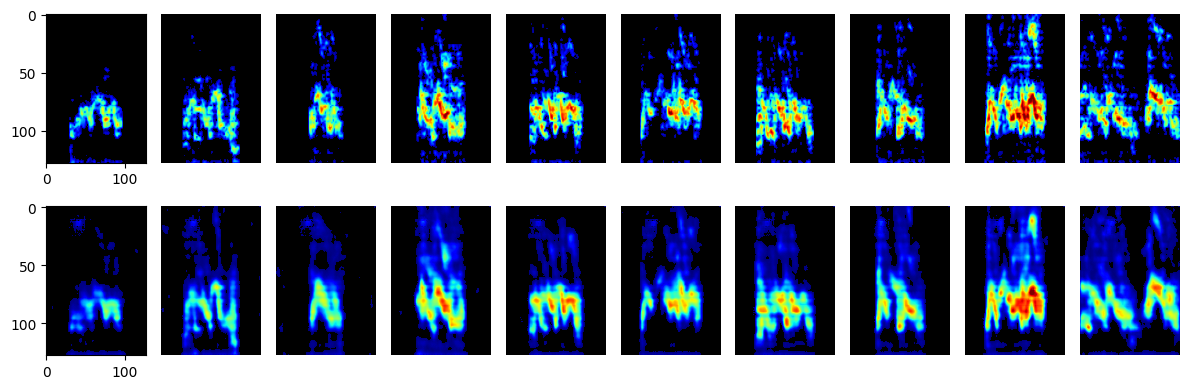

In [9]:
## check recontruction accuracy (optional)
# plot some random samples
fig, ax = plt.subplots(2, 10, figsize=[12,4])
random.seed(1118)
random_i = random.sample(list(range(recon.shape[0])), 10)
with h5py.File(fn_spec, 'r') as file:
    for ii in range(10):
        spec = train_data[random_i[ii],:,:].numpy()
        ax[0][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        spec = recon[random_i[ii],:,:]
        ax[1][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        if ii>0:
            ax[0][ii].axis('off')
            ax[1][ii].axis('off')
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, 'reconstructed_spectrogram.pdf')
fig.savefig(fn_fig)


## 3. Run UMAP/HDBSCAN

In [10]:
# read latent features
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(36296, 32)

In [11]:
# add latent_m to the embedding data frame
embed = info.copy()
for ii in range(latent_m.shape[1]):
    embed[f'vae{ii}'] = latent_m[:,ii]

### UMAP

In [12]:
## run UMAP 
print(param_umap)
umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                              metric=param_umap['metric'], random_state=1118, verbose=True)
res = umap_model.fit_transform(latent_m)

# add UMAP embedding to the dataframe
for jj in range(res.shape[1]):
    embed[f'umap{jj+1}'] = res[:,jj]

{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'cosine'}
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:11:31 2025 Construct fuzzy simplicial set
Fri Jun 13 20:11:31 2025 Finding Nearest Neighbors
Fri Jun 13 20:11:31 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 20:11:33 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 13 20:11:42 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:11:44 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:11:59 2025 Finished embedding


In [13]:
# save the UMAP model for later usage
fn_umap = os.path.join(fd_save, f'UMAPmodel_{bd}.p')
pickle.dump(umap_model, open(fn_umap, 'wb'))

Fri Jun 13 20:12:04 2025 Worst tree score: 0.75479392
Fri Jun 13 20:12:04 2025 Mean tree score: 0.76411726
Fri Jun 13 20:12:04 2025 Best tree score: 0.77135222
Fri Jun 13 20:12:05 2025 Forward diversification reduced edges from 907400 to 324978
Fri Jun 13 20:12:07 2025 Reverse diversification reduced edges from 324978 to 324978
Fri Jun 13 20:12:09 2025 Degree pruning reduced edges from 362372 to 362372
Fri Jun 13 20:12:09 2025 Resorting data and graph based on tree order
Fri Jun 13 20:12:09 2025 Building and compiling search function


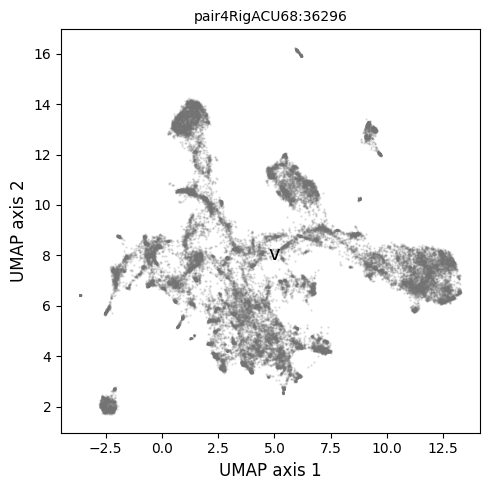

In [15]:
## plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for si, ss in enumerate(syl):
    embed_s = embed[embed['label']==ss]
    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, c='#737373')
    # add syl label
    ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), ss, fontsize=14)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig =os.path.join(fd_save, f'{bd}.UMAPonVAE.embedding.pdf')
fig.savefig(fn_fig)

### HDBSCAN clustering

In [18]:
int(res.shape[0]* param_hdbscan['min_cluster_size_frac'])

1814

In [26]:
## HDBSCAN clustering
# clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
#                             cluster_selection_method=param_hdbscan['select_method'])
clusterer = hdbscan.HDBSCAN(min_cluster_size=1500, min_samples=param_hdbscan['min_samples'],  
                            cluster_selection_method='leaf')
# clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
clusterer.fit(res)
embed['hdbscan_cluster'] = clusterer.labels_ + 1    # no clustering is label 0
embed['hdbscan_prob'] = clusterer.probabilities_

# save embedding and clustering 
fn_embed = os.path.join(fd_save, f'{bd}.{rn}.embedding.csv')
embed.to_csv(fn_embed)

# what's the fraction that's not clustered
unc_f = embed[embed['hdbscan_cluster']==0].shape[0] / embed.shape[0]
print(f'The fraction that are not clustered: {unc_f:.4f}')
num_c = max(embed['hdbscan_cluster'])
print(f'Total number of clusters: {num_c}')

The fraction that are not clustered: 0.3256
Total number of clusters: 6


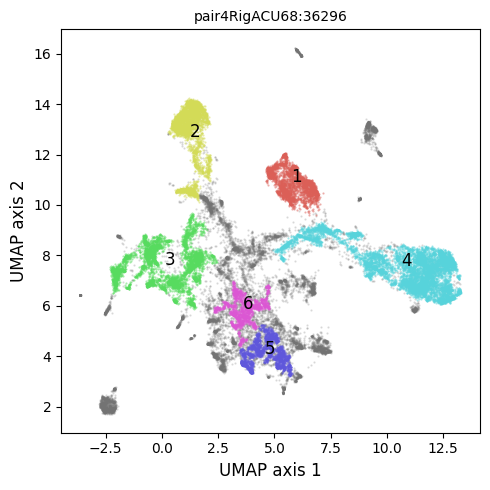

In [27]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster']))
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(0, max(embed['hdbscan_cluster'])+1):
    embed_s = embed[embed['hdbscan_cluster']==hi]
    if hi==0:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, color=col_long[hi-1])
        # add syl label
        ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [28]:
# save HDBSCAN model for future use
fn_cluster = os.path.join(fd_save, f'HDBSCANmodel_{bd}.p')
pickle.dump(clusterer, open(fn_cluster, 'wb'))

In [29]:
# save the color list as well
col_long_np = np.array(col_long)
fn_col = os.path.join(fd_save, 'color.txt')
np.savetxt(fn_col, col_long_np, delimiter=',')

### Quantify clustering quality

In [31]:
## Quantify clustering tendency
# in UMAP space
hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
print(f'Hopkins metric in UMAP: {hpk1:.4f}')
# in VAE space
hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
print(f'Hopkins metric in VAE: {hpk2:.4f}')

## Quantify clustering quality with Silhoutte score
# in UMAP space
sil1 = silhouette_score(res, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
# in VAE space
sil2 = silhouette_score(latent_m, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

# Calinski–Harabasz (CH) Index
cah1 = calinski_harabasz_score(res, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
cah2 = calinski_harabasz_score(latent_m, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

# save data to the master data frame
metrics = pd.DataFrame([{'birdID':bd, 'run_name':rn, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                     'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])

Hopkins metric in UMAP: 0.9847
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: 0.2160
HDBSCAN Silhouette score in VAE: 0.0049
Calinski–Harabasz index in UMAP: 12288.8295
Calinski–Harabasz index in VAE: 1179.4158


In [32]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair4RigACU68,spec_goffinet_cutoff_256_176,6,0.325573,"[0.4342003299702348, 0.4694565046769154, 0.114...",0.984734,0.826297,0.216041,0.00492,12288.829518,1179.415793,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


## 4. Simulate the random datasets

In [33]:
# number of trials to simulate
n = 200

In [34]:
# load the real dataset
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(36296, 32)

In [35]:
 # estimated mean and variance
mu = latent_m.mean(axis=0)                        # empirical mean  (shape: 32,)
Sigma  = np.cov(latent_m, rowvar=False, ddof=1)

In [ ]:
# save metrics in a master dataframe
metrics = pd.DataFrame()
np.random.seed(1118)
for i in tqdm.tqdm(range(n)):
# for i in range(2):
    rng = np.random.default_rng()  
    latent_rd = rng.multivariate_normal(mean=mu, cov=Sigma, size=latent_m.shape[0], method='cholesky')
    
    # then run UMAP and HDBSCAN exactly as for real datasets
    ## run UMAP 
    umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                  metric=param_umap['metric'], random_state=1118, verbose=True)
    res = umap_model.fit_transform(latent_rd)

    ## HDBSCAN clustering
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
    #                             cluster_selection_method=param_hdbscan['select_method'])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=800, min_samples=20, 
                                cluster_selection_method='leaf')
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
    clusterer.fit(res)
    
    labs = clusterer.labels_; 
    # what's the fraction that's not clustered
    unc_f = labs[labs==-1].shape[0] / labs.shape[0]
    print(f'The fraction that are not clustered: {unc_f:.4f}')
    num_c = max(labs+1)
    print(f'Total number of clusters: {num_c}')

    ## Quantify clustering tendency
    # in UMAP space
    hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
    print(f'Hopkins metric in UMAP: {hpk1:.4f}')
    # in VAE space
    hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
    print(f'Hopkins metric in VAE: {hpk2:.4f}')

    ## Quantify clustering quality with Silhoutte score
    # in UMAP space
    sil1 = silhouette_score(res, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
    # in VAE space
    sil2 = silhouette_score(latent_m, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

    # Calinski–Harabasz (CH) Index
    cah1 = calinski_harabasz_score(res, labs)
    print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
    cah2 = calinski_harabasz_score(latent_m, labs)
    print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

    # save data to the master data frame
    row = pd.DataFrame([{'birdID':bd, 'run_id':i, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                         'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])
    metrics = pd.concat([metrics, row], ignore_index=True)

  0%|          | 0/200 [00:00<?, ?it/s]/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:20:46 2025 Construct fuzzy simplicial set
Fri Jun 13 20:20:46 2025 Finding Nearest Neighbors
Fri Jun 13 20:20:46 2025 Building RP forest with 15 trees
Fri Jun 13 20:20:46 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:20:48 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:20:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:21:02 2025 Finished embedding
The fraction that are not clustered: 0.7509
Total number of clusters: 6
Hopkins metric in UMAP: 0.8674
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3120


  0%|          | 1/200 [00:42<2:19:33, 42.08s/it]

HDBSCAN Silhouette score in VAE: -0.0119
Calinski–Harabasz index in UMAP: 1390.7541
Calinski–Harabasz index in VAE: 0.9839
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:21:28 2025 Construct fuzzy simplicial set
Fri Jun 13 20:21:28 2025 Finding Nearest Neighbors
Fri Jun 13 20:21:28 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 20:21:28 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:21:30 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:21:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:21:44 2025 Finished embedding
The fraction that are not clustered: 0.7031
Total number of clusters: 5
Hopkins metric in UMAP: 0.8798
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2951


  1%|          | 2/200 [01:22<2:14:56, 40.89s/it]

HDBSCAN Silhouette score in VAE: -0.0058
Calinski–Harabasz index in UMAP: 1202.5431
Calinski–Harabasz index in VAE: 1.1142
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:22:08 2025 Construct fuzzy simplicial set
Fri Jun 13 20:22:08 2025 Finding Nearest Neighbors
Fri Jun 13 20:22:08 2025 Building RP forest with 15 trees
Fri Jun 13 20:22:08 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:22:10 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:22:10 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:22:24 2025 Finished embedding
The fraction that are not clustered: 0.6162
Total number of clusters: 8
Hopkins metric in UMAP: 0.8951
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2857


  2%|▏         | 3/200 [02:01<2:12:06, 40.24s/it]

HDBSCAN Silhouette score in VAE: -0.0056
Calinski–Harabasz index in UMAP: 1580.0069
Calinski–Harabasz index in VAE: 0.9305
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:22:47 2025 Construct fuzzy simplicial set
Fri Jun 13 20:22:47 2025 Finding Nearest Neighbors
Fri Jun 13 20:22:47 2025 Building RP forest with 15 trees
Fri Jun 13 20:22:47 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:22:49 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:22:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:23:03 2025 Finished embedding
The fraction that are not clustered: 0.6765
Total number of clusters: 6
Hopkins metric in UMAP: 0.8921
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2911


  2%|▏         | 4/200 [02:41<2:10:32, 39.96s/it]

HDBSCAN Silhouette score in VAE: -0.0038
Calinski–Harabasz index in UMAP: 1800.9069
Calinski–Harabasz index in VAE: 0.7711
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:23:27 2025 Construct fuzzy simplicial set
Fri Jun 13 20:23:27 2025 Finding Nearest Neighbors
Fri Jun 13 20:23:27 2025 Building RP forest with 15 trees
Fri Jun 13 20:23:27 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:23:29 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:23:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:23:43 2025 Finished embedding
The fraction that are not clustered: 0.7494
Total number of clusters: 5
Hopkins metric in UMAP: 0.8917
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3199


  2%|▎         | 5/200 [03:20<2:09:14, 39.77s/it]

HDBSCAN Silhouette score in VAE: -0.0075
Calinski–Harabasz index in UMAP: 1212.7575
Calinski–Harabasz index in VAE: 1.0331
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:24:06 2025 Construct fuzzy simplicial set
Fri Jun 13 20:24:06 2025 Finding Nearest Neighbors
Fri Jun 13 20:24:06 2025 Building RP forest with 15 trees
Fri Jun 13 20:24:06 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:24:08 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:24:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:24:22 2025 Finished embedding
The fraction that are not clustered: 0.7300
Total number of clusters: 4
Hopkins metric in UMAP: 0.8711
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2623


  3%|▎         | 6/200 [04:00<2:08:25, 39.72s/it]

HDBSCAN Silhouette score in VAE: -0.0039
Calinski–Harabasz index in UMAP: 1339.9134
Calinski–Harabasz index in VAE: 1.2909
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:24:46 2025 Construct fuzzy simplicial set
Fri Jun 13 20:24:46 2025 Finding Nearest Neighbors
Fri Jun 13 20:24:46 2025 Building RP forest with 15 trees
Fri Jun 13 20:24:46 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:24:48 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:24:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:25:02 2025 Finished embedding
The fraction that are not clustered: 0.6844
Total number of clusters: 6
Hopkins metric in UMAP: 0.9018
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2829


  4%|▎         | 7/200 [04:39<2:07:48, 39.74s/it]

HDBSCAN Silhouette score in VAE: -0.0105
Calinski–Harabasz index in UMAP: 1511.0083
Calinski–Harabasz index in VAE: 0.9409
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:25:26 2025 Construct fuzzy simplicial set
Fri Jun 13 20:25:26 2025 Finding Nearest Neighbors
Fri Jun 13 20:25:26 2025 Building RP forest with 15 trees
Fri Jun 13 20:25:26 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:25:27 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:25:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:25:42 2025 Finished embedding
The fraction that are not clustered: 0.7695
Total number of clusters: 6
Hopkins metric in UMAP: 0.8737
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3522


  4%|▍         | 8/200 [05:20<2:07:46, 39.93s/it]

HDBSCAN Silhouette score in VAE: -0.0064
Calinski–Harabasz index in UMAP: 1169.1954
Calinski–Harabasz index in VAE: 1.2512
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:26:06 2025 Construct fuzzy simplicial set
Fri Jun 13 20:26:06 2025 Finding Nearest Neighbors
Fri Jun 13 20:26:06 2025 Building RP forest with 15 trees
Fri Jun 13 20:26:06 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:26:08 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:26:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:26:22 2025 Finished embedding
The fraction that are not clustered: 0.7231
Total number of clusters: 6
Hopkins metric in UMAP: 0.8945
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3339


  4%|▍         | 9/200 [06:00<2:07:08, 39.94s/it]

HDBSCAN Silhouette score in VAE: -0.0041
Calinski–Harabasz index in UMAP: 1157.1652
Calinski–Harabasz index in VAE: 0.9895
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:26:46 2025 Construct fuzzy simplicial set
Fri Jun 13 20:26:46 2025 Finding Nearest Neighbors
Fri Jun 13 20:26:46 2025 Building RP forest with 15 trees
Fri Jun 13 20:26:46 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:26:48 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:26:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:27:02 2025 Finished embedding
The fraction that are not clustered: 0.6656
Total number of clusters: 5
Hopkins metric in UMAP: 0.8940
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2602


  5%|▌         | 10/200 [06:39<2:05:34, 39.66s/it]

HDBSCAN Silhouette score in VAE: -0.0048
Calinski–Harabasz index in UMAP: 1492.7407
Calinski–Harabasz index in VAE: 1.1482
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:27:25 2025 Construct fuzzy simplicial set
Fri Jun 13 20:27:25 2025 Finding Nearest Neighbors
Fri Jun 13 20:27:25 2025 Building RP forest with 15 trees
Fri Jun 13 20:27:25 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:27:27 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:27:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:27:41 2025 Finished embedding
The fraction that are not clustered: 0.8029
Total number of clusters: 6
Hopkins metric in UMAP: 0.8917
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3939


  6%|▌         | 11/200 [07:19<2:05:40, 39.90s/it]

HDBSCAN Silhouette score in VAE: -0.0045
Calinski–Harabasz index in UMAP: 815.3833
Calinski–Harabasz index in VAE: 0.9847
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:28:05 2025 Construct fuzzy simplicial set
Fri Jun 13 20:28:05 2025 Finding Nearest Neighbors
Fri Jun 13 20:28:05 2025 Building RP forest with 15 trees
Fri Jun 13 20:28:05 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:28:07 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:28:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:28:21 2025 Finished embedding
The fraction that are not clustered: 0.6974
Total number of clusters: 8
Hopkins metric in UMAP: 0.8890
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3236


  6%|▌         | 12/200 [07:59<2:04:41, 39.79s/it]

HDBSCAN Silhouette score in VAE: -0.0086
Calinski–Harabasz index in UMAP: 1472.9311
Calinski–Harabasz index in VAE: 1.1246
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:28:45 2025 Construct fuzzy simplicial set
Fri Jun 13 20:28:45 2025 Finding Nearest Neighbors
Fri Jun 13 20:28:45 2025 Building RP forest with 15 trees
Fri Jun 13 20:28:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:28:47 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:28:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:29:01 2025 Finished embedding
The fraction that are not clustered: 0.7371
Total number of clusters: 8
Hopkins metric in UMAP: 0.8846
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3578


  6%|▋         | 13/200 [08:39<2:04:17, 39.88s/it]

HDBSCAN Silhouette score in VAE: -0.0087
Calinski–Harabasz index in UMAP: 839.3866
Calinski–Harabasz index in VAE: 1.0257
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:29:25 2025 Construct fuzzy simplicial set
Fri Jun 13 20:29:25 2025 Finding Nearest Neighbors
Fri Jun 13 20:29:25 2025 Building RP forest with 15 trees
Fri Jun 13 20:29:25 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:29:27 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:29:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:29:41 2025 Finished embedding
The fraction that are not clustered: 0.6804
Total number of clusters: 7
Hopkins metric in UMAP: 0.8875
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2927


  7%|▋         | 14/200 [09:19<2:03:33, 39.86s/it]

HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 1545.5729
Calinski–Harabasz index in VAE: 1.2430
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:30:05 2025 Construct fuzzy simplicial set
Fri Jun 13 20:30:05 2025 Finding Nearest Neighbors
Fri Jun 13 20:30:05 2025 Building RP forest with 15 trees
Fri Jun 13 20:30:05 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:30:07 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:30:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:30:21 2025 Finished embedding
The fraction that are not clustered: 0.7204
Total number of clusters: 6
Hopkins metric in UMAP: 0.8976
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3163


  8%|▊         | 15/200 [09:59<2:02:58, 39.89s/it]

HDBSCAN Silhouette score in VAE: -0.0051
Calinski–Harabasz index in UMAP: 1283.0894
Calinski–Harabasz index in VAE: 1.0518
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:30:45 2025 Construct fuzzy simplicial set
Fri Jun 13 20:30:45 2025 Finding Nearest Neighbors
Fri Jun 13 20:30:45 2025 Building RP forest with 15 trees
Fri Jun 13 20:30:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:30:47 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:30:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:31:01 2025 Finished embedding
The fraction that are not clustered: 0.7191
Total number of clusters: 9
Hopkins metric in UMAP: 0.8740
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3605


  8%|▊         | 16/200 [10:39<2:02:25, 39.92s/it]

HDBSCAN Silhouette score in VAE: -0.0081
Calinski–Harabasz index in UMAP: 1037.6623
Calinski–Harabasz index in VAE: 0.9341
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:31:25 2025 Construct fuzzy simplicial set
Fri Jun 13 20:31:25 2025 Finding Nearest Neighbors
Fri Jun 13 20:31:25 2025 Building RP forest with 15 trees
Fri Jun 13 20:31:25 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:31:27 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:31:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:31:41 2025 Finished embedding
The fraction that are not clustered: 0.6992
Total number of clusters: 7
Hopkins metric in UMAP: 0.8959
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3257


  8%|▊         | 17/200 [11:18<2:01:40, 39.89s/it]

HDBSCAN Silhouette score in VAE: -0.0093
Calinski–Harabasz index in UMAP: 1339.3151
Calinski–Harabasz index in VAE: 1.2264
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:32:05 2025 Construct fuzzy simplicial set
Fri Jun 13 20:32:05 2025 Finding Nearest Neighbors
Fri Jun 13 20:32:05 2025 Building RP forest with 15 trees
Fri Jun 13 20:32:05 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:32:06 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:32:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:32:21 2025 Finished embedding
The fraction that are not clustered: 0.8092
Total number of clusters: 6
Hopkins metric in UMAP: 0.8817
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3734


  9%|▉         | 18/200 [11:59<2:01:48, 40.16s/it]

HDBSCAN Silhouette score in VAE: -0.0054
Calinski–Harabasz index in UMAP: 754.7460
Calinski–Harabasz index in VAE: 1.0551
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:32:45 2025 Construct fuzzy simplicial set
Fri Jun 13 20:32:45 2025 Finding Nearest Neighbors
Fri Jun 13 20:32:45 2025 Building RP forest with 15 trees
Fri Jun 13 20:32:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:32:47 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:32:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:33:02 2025 Finished embedding
The fraction that are not clustered: 0.6408
Total number of clusters: 5
Hopkins metric in UMAP: 0.8822
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2044


 10%|▉         | 19/200 [12:39<2:00:31, 39.95s/it]

HDBSCAN Silhouette score in VAE: -0.0048
Calinski–Harabasz index in UMAP: 2407.3527
Calinski–Harabasz index in VAE: 0.8309
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:33:25 2025 Construct fuzzy simplicial set
Fri Jun 13 20:33:25 2025 Finding Nearest Neighbors
Fri Jun 13 20:33:25 2025 Building RP forest with 15 trees
Fri Jun 13 20:33:25 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:33:27 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:33:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:33:41 2025 Finished embedding
The fraction that are not clustered: 0.5451
Total number of clusters: 6
Hopkins metric in UMAP: 0.8930
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.1685


 10%|█         | 20/200 [13:18<1:58:53, 39.63s/it]

HDBSCAN Silhouette score in VAE: -0.0039
Calinski–Harabasz index in UMAP: 2746.0105
Calinski–Harabasz index in VAE: 1.0288
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:34:04 2025 Construct fuzzy simplicial set
Fri Jun 13 20:34:04 2025 Finding Nearest Neighbors
Fri Jun 13 20:34:04 2025 Building RP forest with 15 trees
Fri Jun 13 20:34:04 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:34:06 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:34:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:34:20 2025 Finished embedding
The fraction that are not clustered: 0.7419
Total number of clusters: 6
Hopkins metric in UMAP: 0.8933
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3535


 10%|█         | 21/200 [13:58<1:58:49, 39.83s/it]

HDBSCAN Silhouette score in VAE: -0.0112
Calinski–Harabasz index in UMAP: 1027.5169
Calinski–Harabasz index in VAE: 1.1261
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:34:44 2025 Construct fuzzy simplicial set
Fri Jun 13 20:34:44 2025 Finding Nearest Neighbors
Fri Jun 13 20:34:44 2025 Building RP forest with 15 trees
Fri Jun 13 20:34:44 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:34:46 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:34:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:35:00 2025 Finished embedding
The fraction that are not clustered: 0.7461
Total number of clusters: 6
Hopkins metric in UMAP: 0.8902
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3332


 11%|█         | 22/200 [14:38<1:58:28, 39.93s/it]

HDBSCAN Silhouette score in VAE: -0.0054
Calinski–Harabasz index in UMAP: 1190.0805
Calinski–Harabasz index in VAE: 1.0033
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:35:24 2025 Construct fuzzy simplicial set
Fri Jun 13 20:35:24 2025 Finding Nearest Neighbors
Fri Jun 13 20:35:24 2025 Building RP forest with 15 trees
Fri Jun 13 20:35:24 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:35:26 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:35:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:35:41 2025 Finished embedding
The fraction that are not clustered: 0.7183
Total number of clusters: 7
Hopkins metric in UMAP: 0.8949
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3379


 12%|█▏        | 23/200 [15:18<1:58:11, 40.06s/it]

HDBSCAN Silhouette score in VAE: -0.0088
Calinski–Harabasz index in UMAP: 956.4289
Calinski–Harabasz index in VAE: 1.0364
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:36:05 2025 Construct fuzzy simplicial set
Fri Jun 13 20:36:05 2025 Finding Nearest Neighbors
Fri Jun 13 20:36:05 2025 Building RP forest with 15 trees
Fri Jun 13 20:36:05 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:36:06 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:36:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:36:21 2025 Finished embedding
The fraction that are not clustered: 0.7366
Total number of clusters: 6
Hopkins metric in UMAP: 0.8824
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3236


 12%|█▏        | 24/200 [15:59<1:57:37, 40.10s/it]

HDBSCAN Silhouette score in VAE: -0.0075
Calinski–Harabasz index in UMAP: 1093.5356
Calinski–Harabasz index in VAE: 1.2238
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:36:45 2025 Construct fuzzy simplicial set
Fri Jun 13 20:36:45 2025 Finding Nearest Neighbors
Fri Jun 13 20:36:45 2025 Building RP forest with 15 trees
Fri Jun 13 20:36:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:36:47 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:36:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:37:01 2025 Finished embedding
The fraction that are not clustered: 0.7060
Total number of clusters: 5
Hopkins metric in UMAP: 0.8767
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2741


 12%|█▎        | 25/200 [16:38<1:56:41, 40.01s/it]

HDBSCAN Silhouette score in VAE: -0.0058
Calinski–Harabasz index in UMAP: 1482.9062
Calinski–Harabasz index in VAE: 1.0868
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:37:25 2025 Construct fuzzy simplicial set
Fri Jun 13 20:37:25 2025 Finding Nearest Neighbors
Fri Jun 13 20:37:25 2025 Building RP forest with 15 trees
Fri Jun 13 20:37:25 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:37:26 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:37:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:37:41 2025 Finished embedding
The fraction that are not clustered: 0.6696
Total number of clusters: 8
Hopkins metric in UMAP: 0.8862
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2812


 13%|█▎        | 26/200 [17:18<1:55:39, 39.88s/it]

HDBSCAN Silhouette score in VAE: -0.0115
Calinski–Harabasz index in UMAP: 1753.6266
Calinski–Harabasz index in VAE: 0.9332
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:38:04 2025 Construct fuzzy simplicial set
Fri Jun 13 20:38:04 2025 Finding Nearest Neighbors
Fri Jun 13 20:38:04 2025 Building RP forest with 15 trees
Fri Jun 13 20:38:04 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:38:06 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:38:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:38:20 2025 Finished embedding
The fraction that are not clustered: 0.7283
Total number of clusters: 5
Hopkins metric in UMAP: 0.8824
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3174


 14%|█▎        | 27/200 [17:58<1:55:03, 39.90s/it]

HDBSCAN Silhouette score in VAE: -0.0090
Calinski–Harabasz index in UMAP: 1179.3705
Calinski–Harabasz index in VAE: 0.9753
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:38:44 2025 Construct fuzzy simplicial set
Fri Jun 13 20:38:44 2025 Finding Nearest Neighbors
Fri Jun 13 20:38:44 2025 Building RP forest with 15 trees
Fri Jun 13 20:38:44 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:38:46 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:38:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:39:10 2025 Finished embedding
The fraction that are not clustered: 0.6471
Total number of clusters: 7
Hopkins metric in UMAP: 0.8851
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2688


 14%|█▍        | 28/200 [18:47<2:02:12, 42.63s/it]

HDBSCAN Silhouette score in VAE: -0.0080
Calinski–Harabasz index in UMAP: 1733.6604
Calinski–Harabasz index in VAE: 0.8048
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:39:33 2025 Construct fuzzy simplicial set
Fri Jun 13 20:39:33 2025 Finding Nearest Neighbors
Fri Jun 13 20:39:33 2025 Building RP forest with 15 trees
Fri Jun 13 20:39:33 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:39:35 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:39:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:39:50 2025 Finished embedding
The fraction that are not clustered: 0.6424
Total number of clusters: 9
Hopkins metric in UMAP: 0.8835
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3037


 14%|█▍        | 29/200 [19:27<1:58:58, 41.75s/it]

HDBSCAN Silhouette score in VAE: -0.0112
Calinski–Harabasz index in UMAP: 1406.5994
Calinski–Harabasz index in VAE: 0.9326
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:40:13 2025 Construct fuzzy simplicial set
Fri Jun 13 20:40:13 2025 Finding Nearest Neighbors
Fri Jun 13 20:40:13 2025 Building RP forest with 15 trees
Fri Jun 13 20:40:13 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:40:15 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:40:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:40:29 2025 Finished embedding
The fraction that are not clustered: 0.6970
Total number of clusters: 6
Hopkins metric in UMAP: 0.8572
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2932


 15%|█▌        | 30/200 [20:06<1:56:26, 41.10s/it]

HDBSCAN Silhouette score in VAE: -0.0037
Calinski–Harabasz index in UMAP: 1551.7869
Calinski–Harabasz index in VAE: 0.8255
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:40:52 2025 Construct fuzzy simplicial set
Fri Jun 13 20:40:52 2025 Finding Nearest Neighbors
Fri Jun 13 20:40:52 2025 Building RP forest with 15 trees
Fri Jun 13 20:40:52 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:40:54 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:40:54 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:41:09 2025 Finished embedding
The fraction that are not clustered: 0.7857
Total number of clusters: 6
Hopkins metric in UMAP: 0.8957
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3648


 16%|█▌        | 31/200 [20:47<1:55:08, 40.88s/it]

HDBSCAN Silhouette score in VAE: -0.0086
Calinski–Harabasz index in UMAP: 739.9840
Calinski–Harabasz index in VAE: 0.9585
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:41:33 2025 Construct fuzzy simplicial set
Fri Jun 13 20:41:33 2025 Finding Nearest Neighbors
Fri Jun 13 20:41:33 2025 Building RP forest with 15 trees
Fri Jun 13 20:41:33 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:41:35 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:41:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:41:49 2025 Finished embedding
The fraction that are not clustered: 0.6883
Total number of clusters: 9
Hopkins metric in UMAP: 0.8844
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3276


 16%|█▌        | 32/200 [21:26<1:53:19, 40.47s/it]

HDBSCAN Silhouette score in VAE: -0.0102
Calinski–Harabasz index in UMAP: 1166.9037
Calinski–Harabasz index in VAE: 1.3005
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:42:12 2025 Construct fuzzy simplicial set
Fri Jun 13 20:42:12 2025 Finding Nearest Neighbors
Fri Jun 13 20:42:12 2025 Building RP forest with 15 trees
Fri Jun 13 20:42:12 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:42:14 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:42:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:42:28 2025 Finished embedding
The fraction that are not clustered: 0.7875
Total number of clusters: 5
Hopkins metric in UMAP: 0.8769
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3607


 16%|█▋        | 33/200 [22:07<1:52:36, 40.46s/it]

HDBSCAN Silhouette score in VAE: -0.0030
Calinski–Harabasz index in UMAP: 789.6842
Calinski–Harabasz index in VAE: 0.8082
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:42:53 2025 Construct fuzzy simplicial set
Fri Jun 13 20:42:53 2025 Finding Nearest Neighbors
Fri Jun 13 20:42:53 2025 Building RP forest with 15 trees
Fri Jun 13 20:42:53 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:42:55 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:42:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:43:09 2025 Finished embedding
The fraction that are not clustered: 0.6401
Total number of clusters: 8
Hopkins metric in UMAP: 0.9006
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3038


 17%|█▋        | 34/200 [22:46<1:51:07, 40.16s/it]

HDBSCAN Silhouette score in VAE: -0.0098
Calinski–Harabasz index in UMAP: 1377.4123
Calinski–Harabasz index in VAE: 0.8837
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:43:32 2025 Construct fuzzy simplicial set
Fri Jun 13 20:43:32 2025 Finding Nearest Neighbors
Fri Jun 13 20:43:32 2025 Building RP forest with 15 trees
Fri Jun 13 20:43:32 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:43:34 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:43:34 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:43:48 2025 Finished embedding
The fraction that are not clustered: 0.7155
Total number of clusters: 6
Hopkins metric in UMAP: 0.8881
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2932


 18%|█▊        | 35/200 [23:26<1:50:11, 40.07s/it]

HDBSCAN Silhouette score in VAE: -0.0114
Calinski–Harabasz index in UMAP: 1376.3624
Calinski–Harabasz index in VAE: 0.9705
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:44:12 2025 Construct fuzzy simplicial set
Fri Jun 13 20:44:12 2025 Finding Nearest Neighbors
Fri Jun 13 20:44:12 2025 Building RP forest with 15 trees
Fri Jun 13 20:44:12 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:44:14 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:44:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:44:28 2025 Finished embedding
The fraction that are not clustered: 0.6600
Total number of clusters: 8
Hopkins metric in UMAP: 0.9014
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2939


 18%|█▊        | 36/200 [24:05<1:49:06, 39.91s/it]

HDBSCAN Silhouette score in VAE: -0.0053
Calinski–Harabasz index in UMAP: 1300.8592
Calinski–Harabasz index in VAE: 1.2387
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:44:52 2025 Construct fuzzy simplicial set
Fri Jun 13 20:44:52 2025 Finding Nearest Neighbors
Fri Jun 13 20:44:52 2025 Building RP forest with 15 trees
Fri Jun 13 20:44:52 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:44:53 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:44:54 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:45:08 2025 Finished embedding
The fraction that are not clustered: 0.6281
Total number of clusters: 7
Hopkins metric in UMAP: 0.8737
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2947


 18%|█▊        | 37/200 [24:45<1:48:05, 39.79s/it]

HDBSCAN Silhouette score in VAE: -0.0046
Calinski–Harabasz index in UMAP: 1494.4707
Calinski–Harabasz index in VAE: 0.8857
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:45:31 2025 Construct fuzzy simplicial set
Fri Jun 13 20:45:31 2025 Finding Nearest Neighbors
Fri Jun 13 20:45:31 2025 Building RP forest with 15 trees
Fri Jun 13 20:45:31 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:45:33 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:45:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:45:47 2025 Finished embedding
The fraction that are not clustered: 0.6658
Total number of clusters: 7
Hopkins metric in UMAP: 0.8807
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2989


 19%|█▉        | 38/200 [25:25<1:47:19, 39.75s/it]

HDBSCAN Silhouette score in VAE: -0.0056
Calinski–Harabasz index in UMAP: 1478.1805
Calinski–Harabasz index in VAE: 1.3092
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:46:11 2025 Construct fuzzy simplicial set
Fri Jun 13 20:46:11 2025 Finding Nearest Neighbors
Fri Jun 13 20:46:11 2025 Building RP forest with 15 trees
Fri Jun 13 20:46:11 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:46:13 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:46:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:46:27 2025 Finished embedding
The fraction that are not clustered: 0.7138
Total number of clusters: 7
Hopkins metric in UMAP: 0.8822
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3413


 20%|█▉        | 39/200 [26:04<1:46:37, 39.74s/it]

HDBSCAN Silhouette score in VAE: -0.0070
Calinski–Harabasz index in UMAP: 1116.9662
Calinski–Harabasz index in VAE: 1.4163
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:46:50 2025 Construct fuzzy simplicial set
Fri Jun 13 20:46:50 2025 Finding Nearest Neighbors
Fri Jun 13 20:46:50 2025 Building RP forest with 15 trees
Fri Jun 13 20:46:51 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:46:52 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:46:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:47:07 2025 Finished embedding
The fraction that are not clustered: 0.7545
Total number of clusters: 5
Hopkins metric in UMAP: 0.8756
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3092


 20%|██        | 40/200 [26:45<1:46:33, 39.96s/it]

HDBSCAN Silhouette score in VAE: -0.0058
Calinski–Harabasz index in UMAP: 1030.5734
Calinski–Harabasz index in VAE: 0.6154
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:47:31 2025 Construct fuzzy simplicial set
Fri Jun 13 20:47:31 2025 Finding Nearest Neighbors
Fri Jun 13 20:47:31 2025 Building RP forest with 15 trees
Fri Jun 13 20:47:31 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:47:33 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:47:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:47:47 2025 Finished embedding
The fraction that are not clustered: 0.7182
Total number of clusters: 5
Hopkins metric in UMAP: 0.8869
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2918


 20%|██        | 41/200 [27:25<1:45:45, 39.91s/it]

HDBSCAN Silhouette score in VAE: -0.0058
Calinski–Harabasz index in UMAP: 1250.3553
Calinski–Harabasz index in VAE: 0.9595
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:48:11 2025 Construct fuzzy simplicial set
Fri Jun 13 20:48:11 2025 Finding Nearest Neighbors
Fri Jun 13 20:48:11 2025 Building RP forest with 15 trees
Fri Jun 13 20:48:11 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:48:13 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:48:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:48:27 2025 Finished embedding
The fraction that are not clustered: 0.7445
Total number of clusters: 6
Hopkins metric in UMAP: 0.8807
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3406


 21%|██        | 42/200 [28:04<1:44:53, 39.84s/it]

HDBSCAN Silhouette score in VAE: -0.0058
Calinski–Harabasz index in UMAP: 1139.9363
Calinski–Harabasz index in VAE: 1.4369
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:48:50 2025 Construct fuzzy simplicial set
Fri Jun 13 20:48:50 2025 Finding Nearest Neighbors
Fri Jun 13 20:48:50 2025 Building RP forest with 15 trees
Fri Jun 13 20:48:50 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:48:52 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:48:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:49:07 2025 Finished embedding
The fraction that are not clustered: 0.7324
Total number of clusters: 5
Hopkins metric in UMAP: 0.8932
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3211


 22%|██▏       | 43/200 [28:44<1:44:34, 39.96s/it]

HDBSCAN Silhouette score in VAE: -0.0093
Calinski–Harabasz index in UMAP: 1359.3699
Calinski–Harabasz index in VAE: 1.1179
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:49:31 2025 Construct fuzzy simplicial set
Fri Jun 13 20:49:31 2025 Finding Nearest Neighbors
Fri Jun 13 20:49:31 2025 Building RP forest with 15 trees
Fri Jun 13 20:49:31 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:49:32 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:49:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:49:47 2025 Finished embedding
The fraction that are not clustered: 0.6850
Total number of clusters: 9
Hopkins metric in UMAP: 0.8775
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3298


 22%|██▏       | 44/200 [29:24<1:43:39, 39.87s/it]

HDBSCAN Silhouette score in VAE: -0.0068
Calinski–Harabasz index in UMAP: 1272.4179
Calinski–Harabasz index in VAE: 1.1952
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:50:10 2025 Construct fuzzy simplicial set
Fri Jun 13 20:50:10 2025 Finding Nearest Neighbors
Fri Jun 13 20:50:10 2025 Building RP forest with 15 trees
Fri Jun 13 20:50:10 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:50:12 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:50:12 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:50:26 2025 Finished embedding
The fraction that are not clustered: 0.7312
Total number of clusters: 4
Hopkins metric in UMAP: 0.8918
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2339


 22%|██▎       | 45/200 [30:04<1:43:02, 39.89s/it]

HDBSCAN Silhouette score in VAE: -0.0038
Calinski–Harabasz index in UMAP: 1684.1536
Calinski–Harabasz index in VAE: 1.2770
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:50:50 2025 Construct fuzzy simplicial set
Fri Jun 13 20:50:50 2025 Finding Nearest Neighbors
Fri Jun 13 20:50:50 2025 Building RP forest with 15 trees
Fri Jun 13 20:50:50 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:50:52 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:50:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:51:07 2025 Finished embedding
The fraction that are not clustered: 0.6858
Total number of clusters: 7
Hopkins metric in UMAP: 0.8782
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3306


 23%|██▎       | 46/200 [30:44<1:42:23, 39.89s/it]

HDBSCAN Silhouette score in VAE: -0.0077
Calinski–Harabasz index in UMAP: 1231.3100
Calinski–Harabasz index in VAE: 1.1049
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:51:30 2025 Construct fuzzy simplicial set
Fri Jun 13 20:51:30 2025 Finding Nearest Neighbors
Fri Jun 13 20:51:30 2025 Building RP forest with 15 trees
Fri Jun 13 20:51:30 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:51:32 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:51:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:51:46 2025 Finished embedding
The fraction that are not clustered: 0.6696
Total number of clusters: 5
Hopkins metric in UMAP: 0.8757
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2387


 24%|██▎       | 47/200 [31:23<1:41:12, 39.69s/it]

HDBSCAN Silhouette score in VAE: -0.0077
Calinski–Harabasz index in UMAP: 1777.5157
Calinski–Harabasz index in VAE: 1.2929
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:52:09 2025 Construct fuzzy simplicial set
Fri Jun 13 20:52:09 2025 Finding Nearest Neighbors
Fri Jun 13 20:52:09 2025 Building RP forest with 15 trees
Fri Jun 13 20:52:09 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:52:11 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:52:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:52:26 2025 Finished embedding
The fraction that are not clustered: 0.6991
Total number of clusters: 8
Hopkins metric in UMAP: 0.8753
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3388


 24%|██▍       | 48/200 [32:03<1:40:45, 39.78s/it]

HDBSCAN Silhouette score in VAE: -0.0083
Calinski–Harabasz index in UMAP: 1199.5536
Calinski–Harabasz index in VAE: 1.0497
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:52:49 2025 Construct fuzzy simplicial set
Fri Jun 13 20:52:49 2025 Finding Nearest Neighbors
Fri Jun 13 20:52:49 2025 Building RP forest with 15 trees
Fri Jun 13 20:52:49 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:52:51 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:52:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:53:05 2025 Finished embedding
The fraction that are not clustered: 0.7410
Total number of clusters: 5
Hopkins metric in UMAP: 0.8760
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3320


 24%|██▍       | 49/200 [32:43<1:40:13, 39.82s/it]

HDBSCAN Silhouette score in VAE: -0.0037
Calinski–Harabasz index in UMAP: 900.6487
Calinski–Harabasz index in VAE: 1.3294
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:53:29 2025 Construct fuzzy simplicial set
Fri Jun 13 20:53:29 2025 Finding Nearest Neighbors
Fri Jun 13 20:53:29 2025 Building RP forest with 15 trees
Fri Jun 13 20:53:29 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:53:31 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:53:31 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:53:45 2025 Finished embedding
The fraction that are not clustered: 0.7090
Total number of clusters: 6
Hopkins metric in UMAP: 0.8891
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2825


 25%|██▌       | 50/200 [33:22<1:39:11, 39.68s/it]

HDBSCAN Silhouette score in VAE: -0.0029
Calinski–Harabasz index in UMAP: 1671.6234
Calinski–Harabasz index in VAE: 1.0626
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:54:09 2025 Construct fuzzy simplicial set
Fri Jun 13 20:54:09 2025 Finding Nearest Neighbors
Fri Jun 13 20:54:09 2025 Building RP forest with 15 trees
Fri Jun 13 20:54:09 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:54:10 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:54:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:54:25 2025 Finished embedding
The fraction that are not clustered: 0.6956
Total number of clusters: 6
Hopkins metric in UMAP: 0.8862
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2819


 26%|██▌       | 51/200 [34:03<1:38:51, 39.81s/it]

HDBSCAN Silhouette score in VAE: -0.0093
Calinski–Harabasz index in UMAP: 1666.5137
Calinski–Harabasz index in VAE: 1.0446
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:54:49 2025 Construct fuzzy simplicial set
Fri Jun 13 20:54:49 2025 Finding Nearest Neighbors
Fri Jun 13 20:54:49 2025 Building RP forest with 15 trees
Fri Jun 13 20:54:49 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:54:51 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:54:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:55:05 2025 Finished embedding
The fraction that are not clustered: 0.7439
Total number of clusters: 6
Hopkins metric in UMAP: 0.8827
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3164


 26%|██▌       | 52/200 [34:42<1:38:09, 39.80s/it]

HDBSCAN Silhouette score in VAE: -0.0074
Calinski–Harabasz index in UMAP: 1200.8761
Calinski–Harabasz index in VAE: 0.7322
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:55:28 2025 Construct fuzzy simplicial set
Fri Jun 13 20:55:28 2025 Finding Nearest Neighbors
Fri Jun 13 20:55:28 2025 Building RP forest with 15 trees
Fri Jun 13 20:55:29 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:55:30 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:55:31 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:55:45 2025 Finished embedding
The fraction that are not clustered: 0.6951
Total number of clusters: 6
Hopkins metric in UMAP: 0.8760
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2896


 26%|██▋       | 53/200 [35:22<1:37:25, 39.77s/it]

HDBSCAN Silhouette score in VAE: -0.0051
Calinski–Harabasz index in UMAP: 1664.9256
Calinski–Harabasz index in VAE: 0.9396
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:56:08 2025 Construct fuzzy simplicial set
Fri Jun 13 20:56:08 2025 Finding Nearest Neighbors
Fri Jun 13 20:56:08 2025 Building RP forest with 15 trees
Fri Jun 13 20:56:08 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:56:10 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:56:10 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:56:24 2025 Finished embedding
The fraction that are not clustered: 0.6858
Total number of clusters: 7
Hopkins metric in UMAP: 0.8716
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3003


 27%|██▋       | 54/200 [36:02<1:36:41, 39.74s/it]

HDBSCAN Silhouette score in VAE: -0.0082
Calinski–Harabasz index in UMAP: 1532.9088
Calinski–Harabasz index in VAE: 1.0773
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:56:48 2025 Construct fuzzy simplicial set
Fri Jun 13 20:56:48 2025 Finding Nearest Neighbors
Fri Jun 13 20:56:48 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 20:56:48 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:56:50 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:56:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:57:04 2025 Finished embedding
The fraction that are not clustered: 0.6753
Total number of clusters: 7
Hopkins metric in UMAP: 0.8645
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3318


 28%|██▊       | 55/200 [36:41<1:35:57, 39.71s/it]

HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 1093.5768
Calinski–Harabasz index in VAE: 0.9825
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:57:27 2025 Construct fuzzy simplicial set
Fri Jun 13 20:57:27 2025 Finding Nearest Neighbors
Fri Jun 13 20:57:27 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 20:57:28 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:57:29 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:57:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:57:44 2025 Finished embedding
The fraction that are not clustered: 0.7448
Total number of clusters: 7
Hopkins metric in UMAP: 0.8891
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3627


 28%|██▊       | 56/200 [37:21<1:35:37, 39.85s/it]

HDBSCAN Silhouette score in VAE: -0.0024
Calinski–Harabasz index in UMAP: 896.2134
Calinski–Harabasz index in VAE: 1.0352
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:58:08 2025 Construct fuzzy simplicial set
Fri Jun 13 20:58:08 2025 Finding Nearest Neighbors
Fri Jun 13 20:58:08 2025 Building RP forest with 15 trees
Fri Jun 13 20:58:08 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:58:10 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:58:10 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:58:24 2025 Finished embedding
The fraction that are not clustered: 0.7207
Total number of clusters: 7
Hopkins metric in UMAP: 0.8870
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3276


 28%|██▊       | 57/200 [38:01<1:35:05, 39.90s/it]

HDBSCAN Silhouette score in VAE: -0.0064
Calinski–Harabasz index in UMAP: 1292.9237
Calinski–Harabasz index in VAE: 0.9484
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:58:48 2025 Construct fuzzy simplicial set
Fri Jun 13 20:58:48 2025 Finding Nearest Neighbors
Fri Jun 13 20:58:48 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 20:58:48 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:58:50 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:58:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:59:03 2025 Finished embedding
The fraction that are not clustered: 0.8176
Total number of clusters: 5
Hopkins metric in UMAP: 0.8914
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3370


 29%|██▉       | 58/200 [38:42<1:34:35, 39.97s/it]

HDBSCAN Silhouette score in VAE: -0.0122
Calinski–Harabasz index in UMAP: 814.5045
Calinski–Harabasz index in VAE: 1.0977
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 20:59:28 2025 Construct fuzzy simplicial set
Fri Jun 13 20:59:28 2025 Finding Nearest Neighbors
Fri Jun 13 20:59:28 2025 Building RP forest with 15 trees
Fri Jun 13 20:59:28 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 20:59:30 2025 Finished Nearest Neighbor Search
Fri Jun 13 20:59:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 20:59:44 2025 Finished embedding
The fraction that are not clustered: 0.7172
Total number of clusters: 7
Hopkins metric in UMAP: 0.8841
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3414


 30%|██▉       | 59/200 [39:21<1:33:41, 39.87s/it]

HDBSCAN Silhouette score in VAE: -0.0105
Calinski–Harabasz index in UMAP: 1001.8289
Calinski–Harabasz index in VAE: 1.1794
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:00:07 2025 Construct fuzzy simplicial set
Fri Jun 13 21:00:07 2025 Finding Nearest Neighbors
Fri Jun 13 21:00:07 2025 Building RP forest with 15 trees
Fri Jun 13 21:00:08 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:00:09 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:00:10 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:00:23 2025 Finished embedding
The fraction that are not clustered: 0.6811
Total number of clusters: 6
Hopkins metric in UMAP: 0.8702
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2654


 30%|███       | 60/200 [40:01<1:32:45, 39.76s/it]

HDBSCAN Silhouette score in VAE: -0.0048
Calinski–Harabasz index in UMAP: 1989.5572
Calinski–Harabasz index in VAE: 1.1633
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:00:47 2025 Construct fuzzy simplicial set
Fri Jun 13 21:00:47 2025 Finding Nearest Neighbors
Fri Jun 13 21:00:47 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:00:47 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:00:49 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:00:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:01:03 2025 Finished embedding
The fraction that are not clustered: 0.7693
Total number of clusters: 3
Hopkins metric in UMAP: 0.8725
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2535


 30%|███       | 61/200 [40:41<1:32:22, 39.88s/it]

HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 819.9836
Calinski–Harabasz index in VAE: 0.9525
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:01:27 2025 Construct fuzzy simplicial set
Fri Jun 13 21:01:27 2025 Finding Nearest Neighbors
Fri Jun 13 21:01:27 2025 Building RP forest with 15 trees
Fri Jun 13 21:01:27 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:01:29 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:01:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:01:43 2025 Finished embedding
The fraction that are not clustered: 0.6683
Total number of clusters: 4
Hopkins metric in UMAP: 0.8777
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.1965


 31%|███       | 62/200 [41:21<1:31:49, 39.92s/it]

HDBSCAN Silhouette score in VAE: -0.0041
Calinski–Harabasz index in UMAP: 2274.0515
Calinski–Harabasz index in VAE: 1.1868
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:02:07 2025 Construct fuzzy simplicial set
Fri Jun 13 21:02:07 2025 Finding Nearest Neighbors
Fri Jun 13 21:02:07 2025 Building RP forest with 15 trees
Fri Jun 13 21:02:07 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:02:09 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:02:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:02:23 2025 Finished embedding
The fraction that are not clustered: 0.7646
Total number of clusters: 5
Hopkins metric in UMAP: 0.8758
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3220


 32%|███▏      | 63/200 [42:01<1:31:18, 39.99s/it]

HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 1354.3561
Calinski–Harabasz index in VAE: 1.2065
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:02:47 2025 Construct fuzzy simplicial set
Fri Jun 13 21:02:47 2025 Finding Nearest Neighbors
Fri Jun 13 21:02:47 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:02:47 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:02:49 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:02:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:03:03 2025 Finished embedding
The fraction that are not clustered: 0.6364
Total number of clusters: 5
Hopkins metric in UMAP: 0.8870
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2352


 32%|███▏      | 64/200 [42:41<1:30:16, 39.83s/it]

HDBSCAN Silhouette score in VAE: -0.0025
Calinski–Harabasz index in UMAP: 1962.2779
Calinski–Harabasz index in VAE: 1.1999
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:03:27 2025 Construct fuzzy simplicial set
Fri Jun 13 21:03:27 2025 Finding Nearest Neighbors
Fri Jun 13 21:03:27 2025 Building RP forest with 15 trees
Fri Jun 13 21:03:27 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:03:29 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:03:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:03:43 2025 Finished embedding
The fraction that are not clustered: 0.7515
Total number of clusters: 6
Hopkins metric in UMAP: 0.8843
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3346


 32%|███▎      | 65/200 [43:21<1:29:53, 39.95s/it]

HDBSCAN Silhouette score in VAE: -0.0100
Calinski–Harabasz index in UMAP: 1254.2997
Calinski–Harabasz index in VAE: 1.2310
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:04:07 2025 Construct fuzzy simplicial set
Fri Jun 13 21:04:07 2025 Finding Nearest Neighbors
Fri Jun 13 21:04:07 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:04:07 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:04:09 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:04:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:04:23 2025 Finished embedding
The fraction that are not clustered: 0.7067
Total number of clusters: 6
Hopkins metric in UMAP: 0.8867
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2810


 33%|███▎      | 66/200 [44:00<1:29:01, 39.86s/it]

HDBSCAN Silhouette score in VAE: -0.0031
Calinski–Harabasz index in UMAP: 1559.9140
Calinski–Harabasz index in VAE: 0.9686
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:04:47 2025 Construct fuzzy simplicial set
Fri Jun 13 21:04:47 2025 Finding Nearest Neighbors
Fri Jun 13 21:04:47 2025 Building RP forest with 15 trees
Fri Jun 13 21:04:47 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:04:48 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:04:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:05:03 2025 Finished embedding
The fraction that are not clustered: 0.6443
Total number of clusters: 6
Hopkins metric in UMAP: 0.8779
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2540


 34%|███▎      | 67/200 [44:40<1:28:06, 39.75s/it]

HDBSCAN Silhouette score in VAE: -0.0083
Calinski–Harabasz index in UMAP: 1882.6641
Calinski–Harabasz index in VAE: 1.0734
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:05:26 2025 Construct fuzzy simplicial set
Fri Jun 13 21:05:26 2025 Finding Nearest Neighbors
Fri Jun 13 21:05:26 2025 Building RP forest with 15 trees
Fri Jun 13 21:05:26 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:05:28 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:05:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:05:43 2025 Finished embedding
The fraction that are not clustered: 0.7049
Total number of clusters: 6
Hopkins metric in UMAP: 0.8955
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3000


 34%|███▍      | 68/200 [45:20<1:27:43, 39.87s/it]

HDBSCAN Silhouette score in VAE: -0.0089
Calinski–Harabasz index in UMAP: 1400.7296
Calinski–Harabasz index in VAE: 1.1253
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:06:06 2025 Construct fuzzy simplicial set
Fri Jun 13 21:06:06 2025 Finding Nearest Neighbors
Fri Jun 13 21:06:06 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:06:06 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:06:08 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:06:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:06:22 2025 Finished embedding
The fraction that are not clustered: 0.7333
Total number of clusters: 6
Hopkins metric in UMAP: 0.8989
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3360


 34%|███▍      | 69/200 [46:00<1:27:09, 39.92s/it]

HDBSCAN Silhouette score in VAE: -0.0036
Calinski–Harabasz index in UMAP: 1283.1443
Calinski–Harabasz index in VAE: 1.0711
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:06:46 2025 Construct fuzzy simplicial set
Fri Jun 13 21:06:46 2025 Finding Nearest Neighbors
Fri Jun 13 21:06:46 2025 Building RP forest with 15 trees
Fri Jun 13 21:06:46 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:06:48 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:06:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:07:02 2025 Finished embedding
The fraction that are not clustered: 0.7510
Total number of clusters: 5
Hopkins metric in UMAP: 0.8745
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3332


 35%|███▌      | 70/200 [46:40<1:26:34, 39.96s/it]

HDBSCAN Silhouette score in VAE: -0.0061
Calinski–Harabasz index in UMAP: 1047.6985
Calinski–Harabasz index in VAE: 1.1321
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:07:26 2025 Construct fuzzy simplicial set
Fri Jun 13 21:07:26 2025 Finding Nearest Neighbors
Fri Jun 13 21:07:26 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:07:26 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:07:28 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:07:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:07:42 2025 Finished embedding
The fraction that are not clustered: 0.6556
Total number of clusters: 7
Hopkins metric in UMAP: 0.8961
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3085


 36%|███▌      | 71/200 [47:19<1:25:25, 39.73s/it]

HDBSCAN Silhouette score in VAE: -0.0080
Calinski–Harabasz index in UMAP: 1445.6070
Calinski–Harabasz index in VAE: 1.0249
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:08:05 2025 Construct fuzzy simplicial set
Fri Jun 13 21:08:05 2025 Finding Nearest Neighbors
Fri Jun 13 21:08:05 2025 Building RP forest with 15 trees
Fri Jun 13 21:08:06 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:08:07 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:08:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:08:22 2025 Finished embedding
The fraction that are not clustered: 0.7448
Total number of clusters: 3
Hopkins metric in UMAP: 0.8874
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2492


 36%|███▌      | 72/200 [47:59<1:24:55, 39.81s/it]

HDBSCAN Silhouette score in VAE: -0.0031
Calinski–Harabasz index in UMAP: 1066.0430
Calinski–Harabasz index in VAE: 0.9367
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:08:45 2025 Construct fuzzy simplicial set
Fri Jun 13 21:08:45 2025 Finding Nearest Neighbors
Fri Jun 13 21:08:45 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:08:46 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:08:47 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:08:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:09:02 2025 Finished embedding
The fraction that are not clustered: 0.7535
Total number of clusters: 3
Hopkins metric in UMAP: 0.8936
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2245


 36%|███▋      | 73/200 [48:40<1:24:41, 40.01s/it]

HDBSCAN Silhouette score in VAE: -0.0030
Calinski–Harabasz index in UMAP: 1277.5669
Calinski–Harabasz index in VAE: 1.3199
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:09:26 2025 Construct fuzzy simplicial set
Fri Jun 13 21:09:26 2025 Finding Nearest Neighbors
Fri Jun 13 21:09:26 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:09:26 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:09:28 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:09:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:09:42 2025 Finished embedding
The fraction that are not clustered: 0.6093
Total number of clusters: 8
Hopkins metric in UMAP: 0.8849
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2603


 37%|███▋      | 74/200 [49:19<1:23:42, 39.86s/it]

HDBSCAN Silhouette score in VAE: -0.0130
Calinski–Harabasz index in UMAP: 1739.5767
Calinski–Harabasz index in VAE: 1.0025
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:10:05 2025 Construct fuzzy simplicial set
Fri Jun 13 21:10:05 2025 Finding Nearest Neighbors
Fri Jun 13 21:10:05 2025 Building RP forest with 15 trees
Fri Jun 13 21:10:06 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:10:07 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:10:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:10:22 2025 Finished embedding
The fraction that are not clustered: 0.7285
Total number of clusters: 6
Hopkins metric in UMAP: 0.9032
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3375


 38%|███▊      | 75/200 [49:59<1:23:01, 39.85s/it]

HDBSCAN Silhouette score in VAE: -0.0050
Calinski–Harabasz index in UMAP: 1309.8903
Calinski–Harabasz index in VAE: 1.2515
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:10:45 2025 Construct fuzzy simplicial set
Fri Jun 13 21:10:45 2025 Finding Nearest Neighbors
Fri Jun 13 21:10:45 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:10:45 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:10:47 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:10:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:11:02 2025 Finished embedding
The fraction that are not clustered: 0.7073
Total number of clusters: 7
Hopkins metric in UMAP: 0.8797
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3367


 38%|███▊      | 76/200 [50:39<1:22:16, 39.81s/it]

HDBSCAN Silhouette score in VAE: -0.0102
Calinski–Harabasz index in UMAP: 1020.1787
Calinski–Harabasz index in VAE: 0.9809
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:11:25 2025 Construct fuzzy simplicial set
Fri Jun 13 21:11:25 2025 Finding Nearest Neighbors
Fri Jun 13 21:11:25 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:11:25 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:11:27 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:11:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:11:41 2025 Finished embedding
The fraction that are not clustered: 0.6879
Total number of clusters: 9
Hopkins metric in UMAP: 0.8857
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3414


 38%|███▊      | 77/200 [51:19<1:21:30, 39.76s/it]

HDBSCAN Silhouette score in VAE: -0.0077
Calinski–Harabasz index in UMAP: 1010.8801
Calinski–Harabasz index in VAE: 0.8728
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:12:05 2025 Construct fuzzy simplicial set
Fri Jun 13 21:12:05 2025 Finding Nearest Neighbors
Fri Jun 13 21:12:05 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:12:05 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:12:07 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:12:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:12:21 2025 Finished embedding
The fraction that are not clustered: 0.7537
Total number of clusters: 6
Hopkins metric in UMAP: 0.8985
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3473


 39%|███▉      | 78/200 [51:59<1:21:08, 39.91s/it]

HDBSCAN Silhouette score in VAE: -0.0077
Calinski–Harabasz index in UMAP: 808.2307
Calinski–Harabasz index in VAE: 1.0670
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:12:45 2025 Construct fuzzy simplicial set
Fri Jun 13 21:12:45 2025 Finding Nearest Neighbors
Fri Jun 13 21:12:45 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:12:45 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:12:47 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:12:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:13:01 2025 Finished embedding
The fraction that are not clustered: 0.7215
Total number of clusters: 5
Hopkins metric in UMAP: 0.8863
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2796


 40%|███▉      | 79/200 [52:39<1:20:37, 39.98s/it]

HDBSCAN Silhouette score in VAE: -0.0063
Calinski–Harabasz index in UMAP: 1481.5723
Calinski–Harabasz index in VAE: 0.8875
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:13:25 2025 Construct fuzzy simplicial set
Fri Jun 13 21:13:25 2025 Finding Nearest Neighbors
Fri Jun 13 21:13:25 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:13:25 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:13:27 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:13:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:13:41 2025 Finished embedding
The fraction that are not clustered: 0.6528
Total number of clusters: 5
Hopkins metric in UMAP: 0.8914
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2597


 40%|████      | 80/200 [53:18<1:19:42, 39.86s/it]

HDBSCAN Silhouette score in VAE: -0.0122
Calinski–Harabasz index in UMAP: 1629.6486
Calinski–Harabasz index in VAE: 1.2146
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:14:05 2025 Construct fuzzy simplicial set
Fri Jun 13 21:14:05 2025 Finding Nearest Neighbors
Fri Jun 13 21:14:05 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:14:05 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:14:07 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:14:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:14:21 2025 Finished embedding
The fraction that are not clustered: 0.7189
Total number of clusters: 7
Hopkins metric in UMAP: 0.8860
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3280


 40%|████      | 81/200 [53:58<1:19:04, 39.87s/it]

HDBSCAN Silhouette score in VAE: -0.0088
Calinski–Harabasz index in UMAP: 1142.3838
Calinski–Harabasz index in VAE: 1.2654
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:14:45 2025 Construct fuzzy simplicial set
Fri Jun 13 21:14:45 2025 Finding Nearest Neighbors
Fri Jun 13 21:14:45 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:14:45 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:14:46 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:14:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:15:01 2025 Finished embedding
The fraction that are not clustered: 0.7297
Total number of clusters: 6
Hopkins metric in UMAP: 0.8812
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3352


 41%|████      | 82/200 [54:38<1:18:20, 39.83s/it]

HDBSCAN Silhouette score in VAE: -0.0041
Calinski–Harabasz index in UMAP: 1062.6902
Calinski–Harabasz index in VAE: 1.1739
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:15:24 2025 Construct fuzzy simplicial set
Fri Jun 13 21:15:24 2025 Finding Nearest Neighbors
Fri Jun 13 21:15:24 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:15:24 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:15:26 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:15:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:15:40 2025 Finished embedding
The fraction that are not clustered: 0.7278
Total number of clusters: 5
Hopkins metric in UMAP: 0.8808
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2932


 42%|████▏     | 83/200 [55:18<1:17:31, 39.76s/it]

HDBSCAN Silhouette score in VAE: -0.0054
Calinski–Harabasz index in UMAP: 1349.9635
Calinski–Harabasz index in VAE: 0.7930
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:16:04 2025 Construct fuzzy simplicial set
Fri Jun 13 21:16:04 2025 Finding Nearest Neighbors
Fri Jun 13 21:16:04 2025 Building RP forest with 15 trees
Fri Jun 13 21:16:04 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:16:06 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:16:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:16:20 2025 Finished embedding
The fraction that are not clustered: 0.7348
Total number of clusters: 6
Hopkins metric in UMAP: 0.8882
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3307


 42%|████▏     | 84/200 [55:57<1:16:36, 39.63s/it]

HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 1395.0332
Calinski–Harabasz index in VAE: 1.2652
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:16:43 2025 Construct fuzzy simplicial set
Fri Jun 13 21:16:43 2025 Finding Nearest Neighbors
Fri Jun 13 21:16:43 2025 Building RP forest with 15 trees
Fri Jun 13 21:16:43 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:16:45 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:16:45 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:16:59 2025 Finished embedding
The fraction that are not clustered: 0.6814
Total number of clusters: 6
Hopkins metric in UMAP: 0.8870
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2735


 42%|████▎     | 85/200 [56:36<1:15:49, 39.56s/it]

HDBSCAN Silhouette score in VAE: -0.0070
Calinski–Harabasz index in UMAP: 1405.1562
Calinski–Harabasz index in VAE: 0.9400
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:17:23 2025 Construct fuzzy simplicial set
Fri Jun 13 21:17:23 2025 Finding Nearest Neighbors
Fri Jun 13 21:17:23 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:17:23 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:17:25 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:17:25 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:17:39 2025 Finished embedding
The fraction that are not clustered: 0.6604
Total number of clusters: 6
Hopkins metric in UMAP: 0.8843
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2857


 43%|████▎     | 86/200 [57:16<1:15:04, 39.51s/it]

HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 1554.8545
Calinski–Harabasz index in VAE: 0.8654
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:18:02 2025 Construct fuzzy simplicial set
Fri Jun 13 21:18:02 2025 Finding Nearest Neighbors
Fri Jun 13 21:18:02 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:18:02 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:18:04 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:18:04 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:18:18 2025 Finished embedding
The fraction that are not clustered: 0.7688
Total number of clusters: 7
Hopkins metric in UMAP: 0.8828
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3629


 44%|████▎     | 87/200 [57:56<1:14:43, 39.67s/it]

HDBSCAN Silhouette score in VAE: -0.0082
Calinski–Harabasz index in UMAP: 948.8623
Calinski–Harabasz index in VAE: 1.1675
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:18:42 2025 Construct fuzzy simplicial set
Fri Jun 13 21:18:42 2025 Finding Nearest Neighbors
Fri Jun 13 21:18:42 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:18:42 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:18:44 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:18:44 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:18:58 2025 Finished embedding
The fraction that are not clustered: 0.6926
Total number of clusters: 6
Hopkins metric in UMAP: 0.8827
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3093


 44%|████▍     | 88/200 [58:36<1:14:04, 39.68s/it]

HDBSCAN Silhouette score in VAE: -0.0049
Calinski–Harabasz index in UMAP: 1398.3378
Calinski–Harabasz index in VAE: 0.9993
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:19:22 2025 Construct fuzzy simplicial set
Fri Jun 13 21:19:22 2025 Finding Nearest Neighbors
Fri Jun 13 21:19:22 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:19:22 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:19:24 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:19:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:19:38 2025 Finished embedding
The fraction that are not clustered: 0.6775
Total number of clusters: 8
Hopkins metric in UMAP: 0.8901
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3294


 44%|████▍     | 89/200 [59:15<1:13:19, 39.64s/it]

HDBSCAN Silhouette score in VAE: -0.0101
Calinski–Harabasz index in UMAP: 1186.7534
Calinski–Harabasz index in VAE: 1.2088
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:20:01 2025 Construct fuzzy simplicial set
Fri Jun 13 21:20:01 2025 Finding Nearest Neighbors
Fri Jun 13 21:20:01 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:20:01 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:20:03 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:20:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:20:18 2025 Finished embedding
The fraction that are not clustered: 0.6749
Total number of clusters: 6
Hopkins metric in UMAP: 0.8717
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2795


 45%|████▌     | 90/200 [59:55<1:12:50, 39.73s/it]

HDBSCAN Silhouette score in VAE: -0.0063
Calinski–Harabasz index in UMAP: 1563.7593
Calinski–Harabasz index in VAE: 0.8186
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:20:41 2025 Construct fuzzy simplicial set
Fri Jun 13 21:20:41 2025 Finding Nearest Neighbors
Fri Jun 13 21:20:41 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:20:41 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:20:43 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:20:43 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:20:57 2025 Finished embedding
The fraction that are not clustered: 0.7538
Total number of clusters: 6
Hopkins metric in UMAP: 0.8861
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3358


 46%|████▌     | 91/200 [1:00:35<1:12:19, 39.81s/it]

HDBSCAN Silhouette score in VAE: -0.0055
Calinski–Harabasz index in UMAP: 1241.1789
Calinski–Harabasz index in VAE: 1.1064
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:21:21 2025 Construct fuzzy simplicial set
Fri Jun 13 21:21:21 2025 Finding Nearest Neighbors
Fri Jun 13 21:21:21 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:21:21 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:21:23 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:21:23 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:21:37 2025 Finished embedding
The fraction that are not clustered: 0.7055
Total number of clusters: 5
Hopkins metric in UMAP: 0.8860
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2706


 46%|████▌     | 92/200 [1:01:15<1:11:40, 39.82s/it]

HDBSCAN Silhouette score in VAE: -0.0036
Calinski–Harabasz index in UMAP: 1530.3657
Calinski–Harabasz index in VAE: 0.7613
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:22:01 2025 Construct fuzzy simplicial set
Fri Jun 13 21:22:01 2025 Finding Nearest Neighbors
Fri Jun 13 21:22:01 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:22:01 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:22:03 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:22:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:22:17 2025 Finished embedding
The fraction that are not clustered: 0.6230
Total number of clusters: 9
Hopkins metric in UMAP: 0.8915
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2882


 46%|████▋     | 93/200 [1:01:54<1:10:48, 39.71s/it]

HDBSCAN Silhouette score in VAE: -0.0080
Calinski–Harabasz index in UMAP: 1472.1032
Calinski–Harabasz index in VAE: 1.2468
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:22:40 2025 Construct fuzzy simplicial set
Fri Jun 13 21:22:40 2025 Finding Nearest Neighbors
Fri Jun 13 21:22:40 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:22:41 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:22:42 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:22:43 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:22:57 2025 Finished embedding
The fraction that are not clustered: 0.6861
Total number of clusters: 8
Hopkins metric in UMAP: 0.8891
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3374


 47%|████▋     | 94/200 [1:02:34<1:10:05, 39.68s/it]

HDBSCAN Silhouette score in VAE: -0.0110
Calinski–Harabasz index in UMAP: 1133.3660
Calinski–Harabasz index in VAE: 0.8819
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:23:20 2025 Construct fuzzy simplicial set
Fri Jun 13 21:23:20 2025 Finding Nearest Neighbors
Fri Jun 13 21:23:20 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:23:20 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:23:22 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:23:22 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:23:36 2025 Finished embedding
The fraction that are not clustered: 0.6545
Total number of clusters: 7
Hopkins metric in UMAP: 0.8883
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2939


 48%|████▊     | 95/200 [1:03:13<1:09:14, 39.57s/it]

HDBSCAN Silhouette score in VAE: -0.0063
Calinski–Harabasz index in UMAP: 1459.0321
Calinski–Harabasz index in VAE: 0.9893
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:23:59 2025 Construct fuzzy simplicial set
Fri Jun 13 21:23:59 2025 Finding Nearest Neighbors
Fri Jun 13 21:23:59 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:24:00 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:24:01 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:24:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:24:16 2025 Finished embedding
The fraction that are not clustered: 0.6920
Total number of clusters: 6
Hopkins metric in UMAP: 0.8784
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3314


 48%|████▊     | 96/200 [1:03:53<1:08:34, 39.57s/it]

HDBSCAN Silhouette score in VAE: -0.0090
Calinski–Harabasz index in UMAP: 1124.5071
Calinski–Harabasz index in VAE: 1.0448
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:24:39 2025 Construct fuzzy simplicial set
Fri Jun 13 21:24:39 2025 Finding Nearest Neighbors
Fri Jun 13 21:24:39 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:24:39 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:24:41 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:24:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:24:55 2025 Finished embedding
The fraction that are not clustered: 0.7221
Total number of clusters: 4
Hopkins metric in UMAP: 0.8955
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2510


 48%|████▊     | 97/200 [1:04:32<1:07:54, 39.55s/it]

HDBSCAN Silhouette score in VAE: -0.0068
Calinski–Harabasz index in UMAP: 1158.1199
Calinski–Harabasz index in VAE: 1.1143
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:25:18 2025 Construct fuzzy simplicial set
Fri Jun 13 21:25:18 2025 Finding Nearest Neighbors
Fri Jun 13 21:25:18 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:25:19 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:25:20 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:25:21 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:25:34 2025 Finished embedding
The fraction that are not clustered: 0.6782
Total number of clusters: 7
Hopkins metric in UMAP: 0.8999
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3161


 49%|████▉     | 98/200 [1:05:12<1:07:08, 39.50s/it]

HDBSCAN Silhouette score in VAE: -0.0071
Calinski–Harabasz index in UMAP: 1055.1839
Calinski–Harabasz index in VAE: 0.7958
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:25:58 2025 Construct fuzzy simplicial set
Fri Jun 13 21:25:58 2025 Finding Nearest Neighbors
Fri Jun 13 21:25:58 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:25:58 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:26:00 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:26:00 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:26:14 2025 Finished embedding
The fraction that are not clustered: 0.7107
Total number of clusters: 5
Hopkins metric in UMAP: 0.8873
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2818


 50%|████▉     | 99/200 [1:05:51<1:06:37, 39.58s/it]

HDBSCAN Silhouette score in VAE: -0.0063
Calinski–Harabasz index in UMAP: 1647.5722
Calinski–Harabasz index in VAE: 0.8401
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:26:38 2025 Construct fuzzy simplicial set
Fri Jun 13 21:26:38 2025 Finding Nearest Neighbors
Fri Jun 13 21:26:38 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:26:38 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:26:40 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:26:40 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:26:54 2025 Finished embedding
The fraction that are not clustered: 0.7618
Total number of clusters: 8
Hopkins metric in UMAP: 0.8943
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3768


 50%|█████     | 100/200 [1:06:32<1:06:19, 39.79s/it]

HDBSCAN Silhouette score in VAE: -0.0110
Calinski–Harabasz index in UMAP: 848.5355
Calinski–Harabasz index in VAE: 0.8567
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:27:18 2025 Construct fuzzy simplicial set
Fri Jun 13 21:27:18 2025 Finding Nearest Neighbors
Fri Jun 13 21:27:18 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:27:18 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:27:20 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:27:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:27:34 2025 Finished embedding
The fraction that are not clustered: 0.7570
Total number of clusters: 5
Hopkins metric in UMAP: 0.8909
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3103


 50%|█████     | 101/200 [1:07:12<1:05:59, 39.99s/it]

HDBSCAN Silhouette score in VAE: -0.0041
Calinski–Harabasz index in UMAP: 1244.5086
Calinski–Harabasz index in VAE: 0.9933
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:27:58 2025 Construct fuzzy simplicial set
Fri Jun 13 21:27:58 2025 Finding Nearest Neighbors
Fri Jun 13 21:27:58 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:27:59 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:28:00 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:28:01 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:28:15 2025 Finished embedding
The fraction that are not clustered: 0.7404
Total number of clusters: 7
Hopkins metric in UMAP: 0.8745
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3515


 51%|█████     | 102/200 [1:07:52<1:05:25, 40.05s/it]

HDBSCAN Silhouette score in VAE: -0.0038
Calinski–Harabasz index in UMAP: 1133.5115
Calinski–Harabasz index in VAE: 1.0516
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:28:39 2025 Construct fuzzy simplicial set
Fri Jun 13 21:28:39 2025 Finding Nearest Neighbors
Fri Jun 13 21:28:39 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:28:39 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:28:41 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:28:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:28:55 2025 Finished embedding
The fraction that are not clustered: 0.8095
Total number of clusters: 6
Hopkins metric in UMAP: 0.8759
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3832


 52%|█████▏    | 103/200 [1:08:33<1:05:00, 40.21s/it]

HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 970.4127
Calinski–Harabasz index in VAE: 0.6725
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:29:19 2025 Construct fuzzy simplicial set
Fri Jun 13 21:29:19 2025 Finding Nearest Neighbors
Fri Jun 13 21:29:19 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:29:19 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:29:21 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:29:21 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:29:35 2025 Finished embedding
The fraction that are not clustered: 0.7363
Total number of clusters: 5
Hopkins metric in UMAP: 0.8920
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2631


 52%|█████▏    | 104/200 [1:09:13<1:04:13, 40.14s/it]

HDBSCAN Silhouette score in VAE: -0.0061
Calinski–Harabasz index in UMAP: 1653.9269
Calinski–Harabasz index in VAE: 0.9291
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:29:59 2025 Construct fuzzy simplicial set
Fri Jun 13 21:29:59 2025 Finding Nearest Neighbors
Fri Jun 13 21:29:59 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:29:59 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:30:01 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:30:01 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:30:15 2025 Finished embedding
The fraction that are not clustered: 0.6820
Total number of clusters: 6
Hopkins metric in UMAP: 0.8585
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2941


 52%|█████▎    | 105/200 [1:09:53<1:03:18, 39.98s/it]

HDBSCAN Silhouette score in VAE: -0.0080
Calinski–Harabasz index in UMAP: 1403.6221
Calinski–Harabasz index in VAE: 0.7313
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:30:39 2025 Construct fuzzy simplicial set
Fri Jun 13 21:30:39 2025 Finding Nearest Neighbors
Fri Jun 13 21:30:39 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:30:39 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:30:41 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:30:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:30:55 2025 Finished embedding
The fraction that are not clustered: 0.6300
Total number of clusters: 5
Hopkins metric in UMAP: 0.8791
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2272


 53%|█████▎    | 106/200 [1:10:32<1:02:13, 39.72s/it]

HDBSCAN Silhouette score in VAE: -0.0030
Calinski–Harabasz index in UMAP: 1969.3643
Calinski–Harabasz index in VAE: 0.8022
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:31:18 2025 Construct fuzzy simplicial set
Fri Jun 13 21:31:18 2025 Finding Nearest Neighbors
Fri Jun 13 21:31:18 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:31:18 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:31:20 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:31:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:31:34 2025 Finished embedding
The fraction that are not clustered: 0.7181
Total number of clusters: 8
Hopkins metric in UMAP: 0.8877
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3429


 54%|█████▎    | 107/200 [1:11:12<1:01:46, 39.85s/it]

HDBSCAN Silhouette score in VAE: -0.0135
Calinski–Harabasz index in UMAP: 1029.0659
Calinski–Harabasz index in VAE: 1.1031
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:31:58 2025 Construct fuzzy simplicial set
Fri Jun 13 21:31:58 2025 Finding Nearest Neighbors
Fri Jun 13 21:31:58 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:31:58 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:32:00 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:32:00 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:32:14 2025 Finished embedding
The fraction that are not clustered: 0.7561
Total number of clusters: 5
Hopkins metric in UMAP: 0.8887
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3423


 54%|█████▍    | 108/200 [1:11:52<1:01:11, 39.91s/it]

HDBSCAN Silhouette score in VAE: -0.0060
Calinski–Harabasz index in UMAP: 991.5070
Calinski–Harabasz index in VAE: 0.8043
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:32:38 2025 Construct fuzzy simplicial set
Fri Jun 13 21:32:38 2025 Finding Nearest Neighbors
Fri Jun 13 21:32:38 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:32:38 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:32:40 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:32:40 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:32:54 2025 Finished embedding
The fraction that are not clustered: 0.7056
Total number of clusters: 6
Hopkins metric in UMAP: 0.8925
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2965


 55%|█████▍    | 109/200 [1:12:31<1:00:22, 39.81s/it]

HDBSCAN Silhouette score in VAE: -0.0052
Calinski–Harabasz index in UMAP: 1477.5180
Calinski–Harabasz index in VAE: 0.9620
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:33:18 2025 Construct fuzzy simplicial set
Fri Jun 13 21:33:18 2025 Finding Nearest Neighbors
Fri Jun 13 21:33:18 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:33:18 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:33:20 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:33:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:33:34 2025 Finished embedding
The fraction that are not clustered: 0.6518
Total number of clusters: 6
Hopkins metric in UMAP: 0.8943
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2606


 55%|█████▌    | 110/200 [1:13:11<59:29, 39.66s/it]  

HDBSCAN Silhouette score in VAE: -0.0050
Calinski–Harabasz index in UMAP: 1910.1165
Calinski–Harabasz index in VAE: 0.8887
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:33:57 2025 Construct fuzzy simplicial set
Fri Jun 13 21:33:57 2025 Finding Nearest Neighbors
Fri Jun 13 21:33:57 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:33:57 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:33:59 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:33:59 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:34:13 2025 Finished embedding
The fraction that are not clustered: 0.6927
Total number of clusters: 7
Hopkins metric in UMAP: 0.8733
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3174


 56%|█████▌    | 111/200 [1:13:51<58:55, 39.72s/it]

HDBSCAN Silhouette score in VAE: -0.0067
Calinski–Harabasz index in UMAP: 1460.7223
Calinski–Harabasz index in VAE: 0.8836
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:34:37 2025 Construct fuzzy simplicial set
Fri Jun 13 21:34:37 2025 Finding Nearest Neighbors
Fri Jun 13 21:34:37 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:34:37 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:34:39 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:34:39 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:34:53 2025 Finished embedding
The fraction that are not clustered: 0.6637
Total number of clusters: 6
Hopkins metric in UMAP: 0.8743
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2393


 56%|█████▌    | 112/200 [1:14:30<58:08, 39.64s/it]

HDBSCAN Silhouette score in VAE: -0.0044
Calinski–Harabasz index in UMAP: 2043.2868
Calinski–Harabasz index in VAE: 1.1596
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:35:16 2025 Construct fuzzy simplicial set
Fri Jun 13 21:35:16 2025 Finding Nearest Neighbors
Fri Jun 13 21:35:16 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:35:16 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:35:18 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:35:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:35:33 2025 Finished embedding
The fraction that are not clustered: 0.6453
Total number of clusters: 9
Hopkins metric in UMAP: 0.8966
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3219


 56%|█████▋    | 113/200 [1:15:10<57:31, 39.67s/it]

HDBSCAN Silhouette score in VAE: -0.0103
Calinski–Harabasz index in UMAP: 1253.8065
Calinski–Harabasz index in VAE: 1.2298
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:35:56 2025 Construct fuzzy simplicial set
Fri Jun 13 21:35:56 2025 Finding Nearest Neighbors
Fri Jun 13 21:35:56 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:35:56 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:35:58 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:35:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:36:12 2025 Finished embedding
The fraction that are not clustered: 0.6470
Total number of clusters: 10
Hopkins metric in UMAP: 0.8791
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3007


 57%|█████▋    | 114/200 [1:15:49<56:44, 39.58s/it]

HDBSCAN Silhouette score in VAE: -0.0081
Calinski–Harabasz index in UMAP: 1397.3528
Calinski–Harabasz index in VAE: 1.1754
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:36:35 2025 Construct fuzzy simplicial set
Fri Jun 13 21:36:35 2025 Finding Nearest Neighbors
Fri Jun 13 21:36:35 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:36:36 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:36:37 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:36:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:36:52 2025 Finished embedding
The fraction that are not clustered: 0.7435
Total number of clusters: 8
Hopkins metric in UMAP: 0.8782
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3699


 57%|█████▊    | 115/200 [1:16:29<56:16, 39.73s/it]

HDBSCAN Silhouette score in VAE: -0.0134
Calinski–Harabasz index in UMAP: 1022.1991
Calinski–Harabasz index in VAE: 1.1336
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:37:15 2025 Construct fuzzy simplicial set
Fri Jun 13 21:37:15 2025 Finding Nearest Neighbors
Fri Jun 13 21:37:15 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:37:16 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:37:17 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:37:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:37:32 2025 Finished embedding
The fraction that are not clustered: 0.7765
Total number of clusters: 6
Hopkins metric in UMAP: 0.8939
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3158


 58%|█████▊    | 116/200 [1:17:10<55:49, 39.88s/it]

HDBSCAN Silhouette score in VAE: -0.0072
Calinski–Harabasz index in UMAP: 1143.6014
Calinski–Harabasz index in VAE: 1.3945
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:37:56 2025 Construct fuzzy simplicial set
Fri Jun 13 21:37:56 2025 Finding Nearest Neighbors
Fri Jun 13 21:37:56 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:37:56 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:37:58 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:37:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:38:12 2025 Finished embedding
The fraction that are not clustered: 0.6528
Total number of clusters: 9
Hopkins metric in UMAP: 0.8768
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3058


 58%|█████▊    | 117/200 [1:17:49<54:55, 39.71s/it]

HDBSCAN Silhouette score in VAE: -0.0087
Calinski–Harabasz index in UMAP: 1204.7616
Calinski–Harabasz index in VAE: 0.9052
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:38:35 2025 Construct fuzzy simplicial set
Fri Jun 13 21:38:35 2025 Finding Nearest Neighbors
Fri Jun 13 21:38:35 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:38:35 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:38:37 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:38:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:38:51 2025 Finished embedding
The fraction that are not clustered: 0.7275
Total number of clusters: 6
Hopkins metric in UMAP: 0.8780
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3512


 59%|█████▉    | 118/200 [1:18:29<54:24, 39.81s/it]

HDBSCAN Silhouette score in VAE: -0.0129
Calinski–Harabasz index in UMAP: 1026.2892
Calinski–Harabasz index in VAE: 1.1628
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:39:15 2025 Construct fuzzy simplicial set
Fri Jun 13 21:39:15 2025 Finding Nearest Neighbors
Fri Jun 13 21:39:15 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:39:15 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:39:17 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:39:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:39:31 2025 Finished embedding
The fraction that are not clustered: 0.6706
Total number of clusters: 5
Hopkins metric in UMAP: 0.8917
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2658


 60%|█████▉    | 119/200 [1:19:09<53:40, 39.75s/it]

HDBSCAN Silhouette score in VAE: -0.0078
Calinski–Harabasz index in UMAP: 2106.8223
Calinski–Harabasz index in VAE: 0.8438
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:39:55 2025 Construct fuzzy simplicial set
Fri Jun 13 21:39:55 2025 Finding Nearest Neighbors
Fri Jun 13 21:39:55 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:39:55 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:39:57 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:39:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:40:11 2025 Finished embedding
The fraction that are not clustered: 0.7442
Total number of clusters: 5
Hopkins metric in UMAP: 0.8869
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3081


 60%|██████    | 120/200 [1:19:49<53:06, 39.83s/it]

HDBSCAN Silhouette score in VAE: -0.0075
Calinski–Harabasz index in UMAP: 1053.5124
Calinski–Harabasz index in VAE: 1.0427
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:40:35 2025 Construct fuzzy simplicial set
Fri Jun 13 21:40:35 2025 Finding Nearest Neighbors
Fri Jun 13 21:40:35 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:40:35 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:40:37 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:40:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:40:51 2025 Finished embedding
The fraction that are not clustered: 0.6724
Total number of clusters: 7
Hopkins metric in UMAP: 0.8890
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3039


 60%|██████    | 121/200 [1:20:28<52:23, 39.80s/it]

HDBSCAN Silhouette score in VAE: -0.0096
Calinski–Harabasz index in UMAP: 1107.1996
Calinski–Harabasz index in VAE: 1.0478
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:41:14 2025 Construct fuzzy simplicial set
Fri Jun 13 21:41:14 2025 Finding Nearest Neighbors
Fri Jun 13 21:41:14 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:41:15 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:41:16 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:41:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:41:30 2025 Finished embedding
The fraction that are not clustered: 0.8047
Total number of clusters: 5
Hopkins metric in UMAP: 0.8983
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3314


 61%|██████    | 122/200 [1:21:08<51:53, 39.92s/it]

HDBSCAN Silhouette score in VAE: -0.0124
Calinski–Harabasz index in UMAP: 647.7538
Calinski–Harabasz index in VAE: 0.8257
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:41:55 2025 Construct fuzzy simplicial set
Fri Jun 13 21:41:55 2025 Finding Nearest Neighbors
Fri Jun 13 21:41:55 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:41:55 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:41:57 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:41:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:42:11 2025 Finished embedding
The fraction that are not clustered: 0.6381
Total number of clusters: 8
Hopkins metric in UMAP: 0.8916
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3008


 62%|██████▏   | 123/200 [1:21:48<50:58, 39.73s/it]

HDBSCAN Silhouette score in VAE: -0.0059
Calinski–Harabasz index in UMAP: 1441.7797
Calinski–Harabasz index in VAE: 1.1127
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:42:34 2025 Construct fuzzy simplicial set
Fri Jun 13 21:42:34 2025 Finding Nearest Neighbors
Fri Jun 13 21:42:34 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:42:34 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:42:36 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:42:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:42:50 2025 Finished embedding
The fraction that are not clustered: 0.7815
Total number of clusters: 8
Hopkins metric in UMAP: 0.8825
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.4044


 62%|██████▏   | 124/200 [1:22:28<50:38, 39.98s/it]

HDBSCAN Silhouette score in VAE: -0.0093
Calinski–Harabasz index in UMAP: 713.0579
Calinski–Harabasz index in VAE: 1.0398
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:43:14 2025 Construct fuzzy simplicial set
Fri Jun 13 21:43:14 2025 Finding Nearest Neighbors
Fri Jun 13 21:43:14 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:43:15 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:43:16 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:43:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:43:31 2025 Finished embedding
The fraction that are not clustered: 0.6782
Total number of clusters: 8
Hopkins metric in UMAP: 0.8907
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3165


 62%|██████▎   | 125/200 [1:23:08<49:48, 39.85s/it]

HDBSCAN Silhouette score in VAE: -0.0122
Calinski–Harabasz index in UMAP: 1087.6849
Calinski–Harabasz index in VAE: 1.0992
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:43:54 2025 Construct fuzzy simplicial set
Fri Jun 13 21:43:54 2025 Finding Nearest Neighbors
Fri Jun 13 21:43:54 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:43:54 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:43:56 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:43:56 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:44:10 2025 Finished embedding
The fraction that are not clustered: 0.6630
Total number of clusters: 6
Hopkins metric in UMAP: 0.8915
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2892


 63%|██████▎   | 126/200 [1:23:47<48:59, 39.72s/it]

HDBSCAN Silhouette score in VAE: -0.0103
Calinski–Harabasz index in UMAP: 1424.2548
Calinski–Harabasz index in VAE: 0.8499
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:44:33 2025 Construct fuzzy simplicial set
Fri Jun 13 21:44:33 2025 Finding Nearest Neighbors
Fri Jun 13 21:44:33 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:44:34 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:44:35 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:44:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:44:50 2025 Finished embedding
The fraction that are not clustered: 0.7899
Total number of clusters: 7
Hopkins metric in UMAP: 0.8642
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.4006


 64%|██████▎   | 127/200 [1:24:28<48:34, 39.92s/it]

HDBSCAN Silhouette score in VAE: -0.0096
Calinski–Harabasz index in UMAP: 709.9084
Calinski–Harabasz index in VAE: 1.0178
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:45:14 2025 Construct fuzzy simplicial set
Fri Jun 13 21:45:14 2025 Finding Nearest Neighbors
Fri Jun 13 21:45:14 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:45:14 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:45:16 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:45:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:45:30 2025 Finished embedding
The fraction that are not clustered: 0.7202
Total number of clusters: 7
Hopkins metric in UMAP: 0.8832
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3105


 64%|██████▍   | 128/200 [1:25:08<47:54, 39.92s/it]

HDBSCAN Silhouette score in VAE: -0.0111
Calinski–Harabasz index in UMAP: 1281.6636
Calinski–Harabasz index in VAE: 0.7341
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:45:54 2025 Construct fuzzy simplicial set
Fri Jun 13 21:45:54 2025 Finding Nearest Neighbors
Fri Jun 13 21:45:54 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:45:54 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:45:56 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:45:56 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:46:10 2025 Finished embedding
The fraction that are not clustered: 0.6766
Total number of clusters: 8
Hopkins metric in UMAP: 0.8743
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3105


 64%|██████▍   | 129/200 [1:25:47<47:12, 39.90s/it]

HDBSCAN Silhouette score in VAE: -0.0066
Calinski–Harabasz index in UMAP: 1577.2940
Calinski–Harabasz index in VAE: 1.2003
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:46:34 2025 Construct fuzzy simplicial set
Fri Jun 13 21:46:34 2025 Finding Nearest Neighbors
Fri Jun 13 21:46:34 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:46:34 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:46:35 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:46:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:46:50 2025 Finished embedding
The fraction that are not clustered: 0.6911
Total number of clusters: 9
Hopkins metric in UMAP: 0.8813
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3397


 65%|██████▌   | 130/200 [1:26:27<46:21, 39.74s/it]

HDBSCAN Silhouette score in VAE: -0.0094
Calinski–Harabasz index in UMAP: 1123.3542
Calinski–Harabasz index in VAE: 0.8151
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:47:13 2025 Construct fuzzy simplicial set
Fri Jun 13 21:47:13 2025 Finding Nearest Neighbors
Fri Jun 13 21:47:13 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:47:13 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:47:15 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:47:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:47:29 2025 Finished embedding
The fraction that are not clustered: 0.6885
Total number of clusters: 5
Hopkins metric in UMAP: 0.8827
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2664


 66%|██████▌   | 131/200 [1:27:06<45:40, 39.71s/it]

HDBSCAN Silhouette score in VAE: -0.0056
Calinski–Harabasz index in UMAP: 1625.4093
Calinski–Harabasz index in VAE: 1.2519
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:47:53 2025 Construct fuzzy simplicial set
Fri Jun 13 21:47:53 2025 Finding Nearest Neighbors
Fri Jun 13 21:47:53 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:47:53 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:47:54 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:47:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:48:09 2025 Finished embedding
The fraction that are not clustered: 0.6938
Total number of clusters: 7
Hopkins metric in UMAP: 0.8773
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3136


 66%|██████▌   | 132/200 [1:27:46<45:06, 39.81s/it]

HDBSCAN Silhouette score in VAE: -0.0073
Calinski–Harabasz index in UMAP: 1482.0971
Calinski–Harabasz index in VAE: 0.8077
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:48:33 2025 Construct fuzzy simplicial set
Fri Jun 13 21:48:33 2025 Finding Nearest Neighbors
Fri Jun 13 21:48:33 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:48:33 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:48:35 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:48:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:48:49 2025 Finished embedding
The fraction that are not clustered: 0.7246
Total number of clusters: 7
Hopkins metric in UMAP: 0.8854
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3409


 66%|██████▋   | 133/200 [1:28:27<44:36, 39.95s/it]

HDBSCAN Silhouette score in VAE: -0.0087
Calinski–Harabasz index in UMAP: 1069.9842
Calinski–Harabasz index in VAE: 1.2714
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:49:13 2025 Construct fuzzy simplicial set
Fri Jun 13 21:49:13 2025 Finding Nearest Neighbors
Fri Jun 13 21:49:13 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:49:13 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:49:15 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:49:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:49:29 2025 Finished embedding
The fraction that are not clustered: 0.7950
Total number of clusters: 6
Hopkins metric in UMAP: 0.8957
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3702


 67%|██████▋   | 134/200 [1:29:08<44:25, 40.38s/it]

HDBSCAN Silhouette score in VAE: -0.0055
Calinski–Harabasz index in UMAP: 1132.3273
Calinski–Harabasz index in VAE: 0.7071
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:49:54 2025 Construct fuzzy simplicial set
Fri Jun 13 21:49:54 2025 Finding Nearest Neighbors
Fri Jun 13 21:49:54 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:49:54 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:49:57 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:49:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:50:14 2025 Finished embedding
The fraction that are not clustered: 0.6739
Total number of clusters: 7
Hopkins metric in UMAP: 0.8686
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2854


 68%|██████▊   | 135/200 [1:29:59<47:07, 43.50s/it]

HDBSCAN Silhouette score in VAE: -0.0069
Calinski–Harabasz index in UMAP: 1499.2253
Calinski–Harabasz index in VAE: 0.8101
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:50:45 2025 Construct fuzzy simplicial set
Fri Jun 13 21:50:45 2025 Finding Nearest Neighbors
Fri Jun 13 21:50:45 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:50:46 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:50:49 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:50:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:51:09 2025 Finished embedding
The fraction that are not clustered: 0.6594
Total number of clusters: 5
Hopkins metric in UMAP: 0.8828
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.2537


 68%|██████▊   | 136/200 [1:30:49<48:21, 45.34s/it]

HDBSCAN Silhouette score in VAE: -0.0079
Calinski–Harabasz index in UMAP: 1400.1740
Calinski–Harabasz index in VAE: 1.1233
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:51:35 2025 Construct fuzzy simplicial set
Fri Jun 13 21:51:35 2025 Finding Nearest Neighbors
Fri Jun 13 21:51:35 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:51:35 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:51:37 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:51:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:51:51 2025 Finished embedding
The fraction that are not clustered: 0.7684
Total number of clusters: 5
Hopkins metric in UMAP: 0.8981
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3190


 68%|██████▊   | 137/200 [1:31:29<46:03, 43.87s/it]

HDBSCAN Silhouette score in VAE: -0.0058
Calinski–Harabasz index in UMAP: 1172.5651
Calinski–Harabasz index in VAE: 0.8910
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 13 21:52:15 2025 Construct fuzzy simplicial set
Fri Jun 13 21:52:15 2025 Finding Nearest Neighbors
Fri Jun 13 21:52:15 2025 Building RP forest with 15 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Fri Jun 13 21:52:15 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Fri Jun 13 21:52:17 2025 Finished Nearest Neighbor Search
Fri Jun 13 21:52:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 13 21:52:31 2025 Finished embedding
The fraction that are not clustered: 0.7254
Total number of clusters: 7
Hopkins metric in UMAP: 0.8688
Hopkins metric in VAE: 0.8263
HDBSCAN Silhouette score in UMAP: -0.3331


In [48]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
print(metrics.shape)
metrics.head()

(200, 13)


,birdID,run_id,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair4RigACU68,0,6,0.750882,"[0.011746434183319774, 0.019915831340292914, 0...",0.867373,0.826297,-0.312050,-0.011923,1390.754082,0.983863,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
1,pair4RigACU68,1,5,0.703108,"[0.044779437816587685, 0.0027912968629708297, ...",0.879811,0.826297,-0.295131,-0.005828,1202.543119,1.114188,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
2,pair4RigACU68,2,8,0.616239,"[0.009117394884579029, 0.04986995910882574, 0....",0.895053,0.826297,-0.285710,-0.005608,1580.006949,0.930510,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
3,pair4RigACU68,3,6,0.676466,"[0.016319393285056605, 0.03345828676437877, 0....",0.892095,0.826297,-0.291120,-0.003760,1800.906884,0.771136,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
4,pair4RigACU68,4,5,0.749421,"[0.02739745694262073, 0.012203900363069098, 0....",0.891669,0.826297,-0.319892,-0.007513,1212.757471,1.033109,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


### Plot the random distribution of clustering metrics

In [49]:
# read the metric on real dataset
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metric_r = pd.read_csv(fn_metric, index_col=0)
metric_r

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair4RigACU68,spec_goffinet_cutoff_256_176,6,0.325573,[0.43420033 0.4694565 0.11448847 0.27176459 0...,0.984734,0.826297,0.216041,0.00492,12288.829518,1179.415793,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


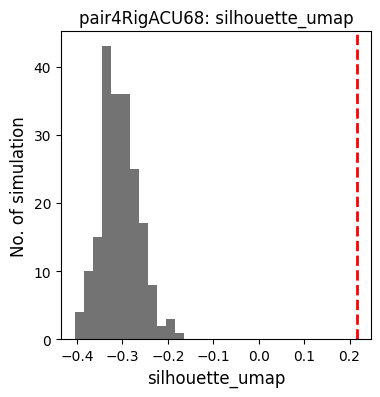

In [50]:
field = 'silhouette_umap'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])
d = metrics[field]
bin_width = 0.02
bins = np.arange(min(d), max(d) + bin_width, bin_width)
ax.hist(d, bins=bins, color='#737373', edgecolor='none')
# add a line for the real data
ax.axvline(x=metric_r[field][0], color='red', linestyle='--', linewidth=2)
ax.set_xlabel(field, fontsize=12)
ax.set_ylabel('No. of simulation', fontsize=12)
ax.set_title(f'{bd}: {field}', fontsize=12)
# save as pdf
fn_pdf = os.path.join(fd_save, f'random.hist.{field}.pdf')
fig.savefig(fn_pdf)

### Plot an example random embedding 

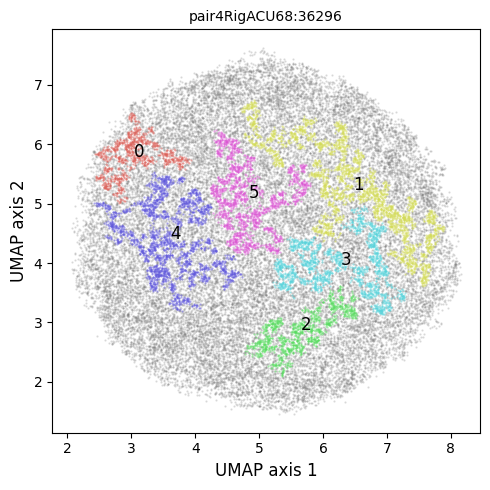

In [51]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(clusterer.labels_)+1)
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(-1, max(clusterer.labels_)+1):
    idx = np.where(clusterer.labels_ == hi)[0]
    embed_s = res[idx,:]
    if hi==-1:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.5, color=col_long[hi])
        # add syl label
        ax.text(np.mean(embed_s[:,0]), np.mean(embed_s[:,1]), hi, fontsize=12)
ax.set_title(f'{bd}:{info.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [52]:
# save the embedding data to plot in Matlab 
embed_r = info.copy()
# save the latent features
for ii in range(latent_rd.shape[1]):
    embed_r[f'vae{ii}'] = latent_rd[:,ii]
# save the UMAP and HDBSCAN results
for ii in range(res.shape[1]):
    embed_r[f'umap{ii+1}'] = res[:,ii]
embed_r['hdbscan_cluster'] = clusterer.labels_+1
embed_r['hdbscan_prob'] = clusterer.probabilities_
fn_csv = os.path.join(fd_save, f'{bd}.random.embedding.csv')
embed_r.to_csv(fn_csv)

In [53]:
print(fn_csv)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigACU68/UMAPonVAE6/v/spec_goffinet_cutoff_256_176/pair4RigACU68.random.embedding.csv


In [54]:
embed_r.shape

(36296, 43)